# P3 - Open Food Facts - Nettoyage et Exploration

### Import

In [1347]:
import sys
import logging
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

### Error Management

In [1348]:
logging.basicConfig(level=logging.INFO)

In [1349]:
# Les separateurs ne sont pas des comma habituelles, ici il sagit de tabulation. low_memory=False est precise
data = pd.read_csv('../Source/fr.openfoodfacts.org.products.csv', sep='\t', low_memory=False, encoding='UTF-8')

### Description du jeu de donnee

In [1350]:
data_shape = data.shape
print(f"Le jeu de donnee contient {data_shape[0]} lignes et {data_shape[1]} colonnes.")

Le jeu de donnee contient 320772 lignes et 162 colonnes.


### Description variable categorielle

In [1351]:
data_lignes = data_shape[0]
desc_var = data.describe(exclude=[np.number])

desc_type = pd.DataFrame(desc_var.dtypes, columns=['type']).T
nb_nan = data_lignes - desc_var.loc['count'].T
pourcentage_nan = nb_nan * 100 / data_lignes
desc_nan = pd.DataFrame([nb_nan, pourcentage_nan], index=['nb_nan', '%_nan'])
desc_var = pd.concat([desc_type, desc_nan, desc_var])

In [1352]:
desc_var

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,states,states_tags,states_fr,main_category,main_category_fr,image_url,image_small_url
type,object,object,object,object,object,object,object,object,object,object,...,object,object,object,object,object,object,object,object,object,object
nb_nan,23.0,23.0,2.0,3.0,9.0,0.0,0.0,17762.0,267977.0,215953.0,...,99562.0,229259.0,226281.0,46.0,46.0,46.0,236406.0,236406.0,244936.0,244936.0
%_nan,0.00717,0.00717,0.000623,0.000935,0.002806,0.0,0.0,5.537266,83.541269,67.322896,...,31.038245,71.471014,70.542628,0.01434,0.01434,0.01434,73.699076,73.699076,76.358286,76.358286
count,320749,320749,320770,320769,320763,320772,320772,303010,52795,104819,...,221210,91513,94491,320726,320726,320726,84366,84366,75836,75836
unique,320749,320749,3535,189567,189568,180495,180495,221347,38584,13826,...,5,14,42,1021,1021,1021,3543,3543,75836,75836
top,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489077120,2017-03-09T10:37:09Z,1439141742,2015-08-09T17:35:42Z,Ice Cream,Pâtes alimentaires au blé dur de qualité supér...,500 g,...,d,unknown,unknown,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","A compléter,Informations nutritionnelles compl...",en:beverages,Boissons,http://fr.openfoodfacts.org/images/products/00...,http://fr.openfoodfacts.org/images/products/00...
freq,1,1,169868,20,20,33,33,410,201,4669,...,62763,22624,22624,168905,168905,168905,6054,6054,1,1


#### 23 unites de difference entre le nombre de ligne (320772) et le nombre de code (320449)

### Description variable quantitatve

In [1353]:
data_lignes = data_shape[0]
desc_var = data.describe()

desc_type = pd.DataFrame(desc_var.dtypes, columns=['type']).T
nb_nan = data_lignes - desc_var.loc['count'].T
pourcentage_nan = nb_nan * 100 / data_lignes
desc_nan = pd.DataFrame([nb_nan, pourcentage_nan], index=['nb_nan', '%_nan'])
desc_var = pd.concat([desc_type, desc_nan, desc_var])

In [1354]:
desc_var

,no_nutriments,additives_n,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,nutrition_grade_uk,energy_100g,energy-from-fat_100g,fat_100g,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
type,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
nb_nan,320772.0,71833.0,71833.0,320772.0,71833.0,320772.0,320772.0,59659.0,319915.0,76881.0,...,320723.0,317736.0,320607.0,319824.0,320772.0,320504.0,99562.0,99562.0,320772.0,320772.0
%_nan,100.0,22.393787,22.393787,100.0,22.393787,100.0,100.0,18.598568,99.732832,23.967491,...,99.984724,99.053533,99.948562,99.704463,100.0,99.916452,31.038245,31.038245,100.0,100.0
count,0.0,248939.0,248939.0,0.0,248939.0,0.0,0.0,261113.0,857.0,243891.0,...,49.0,3036.0,165.0,948.0,0.0,268.0,221210.0,221210.0,0.0,0.0
mean,NaN,1.936024,0.019659,NaN,0.055246,NaN,NaN,1141.914605,585.501214,12.730379,...,6.425698,31.458587,15.412121,49.547785,NaN,341.700764,9.165535,9.058049,NaN,NaN
std,NaN,2.502019,0.140524,NaN,0.269207,NaN,NaN,6447.154093,712.809943,17.578747,...,2.047841,31.967918,3.753028,18.757932,NaN,425.211439,9.055903,9.183589,NaN,NaN
min,NaN,0.0,0.0,NaN,0.0,NaN,NaN,0.0,0.0,0.0,...,0.0,0.0,8.0,6.0,NaN,0.0,-15.0,-15.0,NaN,NaN
25%,NaN,0.0,0.0,NaN,0.0,NaN,NaN,377.0,49.4,0.0,...,6.3,0.0,12.0,32.0,NaN,98.75,1.0,1.0,NaN,NaN
50%,NaN,1.0,0.0,NaN,0.0,NaN,NaN,1100.0,300.0,5.0,...,7.2,23.0,15.0,50.0,NaN,195.75,10.0,9.0,NaN,NaN
75%,NaN,3.0,0.0,NaN,0.0,NaN,NaN,1674.0,898.0,20.0,...,7.4,51.0,15.0,64.25,NaN,383.2,16.0,16.0,NaN,NaN


#### On remarque que dans plusieurs colonnes _100g, des valeurs supperieurs a 100 sont presentes

In [1355]:
data.head(5)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,0000000004559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,0000000016087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,0000000016094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1356]:
data.columns.to_list()

['code',
 'url',
 'creator',
 'created_t',
 'created_datetime',
 'last_modified_t',
 'last_modified_datetime',
 'product_name',
 'generic_name',
 'quantity',
 'packaging',
 'packaging_tags',
 'brands',
 'brands_tags',
 'categories',
 'categories_tags',
 'categories_fr',
 'origins',
 'origins_tags',
 'manufacturing_places',
 'manufacturing_places_tags',
 'labels',
 'labels_tags',
 'labels_fr',
 'emb_codes',
 'emb_codes_tags',
 'first_packaging_code_geo',
 'cities',
 'cities_tags',
 'purchase_places',
 'stores',
 'countries',
 'countries_tags',
 'countries_fr',
 'ingredients_text',
 'allergens',
 'allergens_fr',
 'traces',
 'traces_tags',
 'traces_fr',
 'serving_size',
 'no_nutriments',
 'additives_n',
 'additives',
 'additives_tags',
 'additives_fr',
 'ingredients_from_palm_oil_n',
 'ingredients_from_palm_oil',
 'ingredients_from_palm_oil_tags',
 'ingredients_that_may_be_from_palm_oil_n',
 'ingredients_that_may_be_from_palm_oil',
 'ingredients_that_may_be_from_palm_oil_tags',
 'nutritio

In [1357]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320772 entries, 0 to 320771
Columns: 162 entries, code to water-hardness_100g
dtypes: float64(106), object(56)
memory usage: 396.5+ MB


In [1358]:
data.dtypes

code                        object
url                         object
creator                     object
created_t                   object
created_datetime            object
                            ...   
carbon-footprint_100g      float64
nutrition-score-fr_100g    float64
nutrition-score-uk_100g    float64
glycemic-index_100g        float64
water-hardness_100g        float64
Length: 162, dtype: object

In [1359]:
values = data.dtypes.value_counts()
nb_tot = values.sum()
percentages = round((100 * values / nb_tot), 2)
table = pd.concat([values, percentages], axis=1)
table.columns = ['Nombre par type de variable', '% des types de variable']

In [1360]:
table.loc[table['Nombre par type de variable'] != 0].sort_values('% des types de variable', ascending=False).style.background_gradient('seismic')

,Nombre par type de variable,% des types de variable
float64,106,65.430000
object,56,34.570000


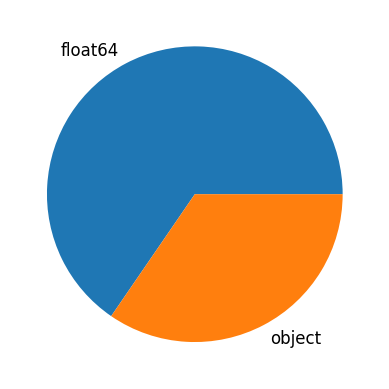

In [1361]:
# Pie chart
data.dtypes.value_counts().plot.pie()
plt.ylabel('')
plt.show()

In [1362]:
# pourcentage des valeurs manquantes
nan_tot =  data.isna().sum().sum()
data_tot = np.product(data.shape)
percentage = round((nan_tot / data_tot) * 100, 2)
print(f'Valeurs manquantes :{nan_tot} NaN pour {data_tot} données ({percentage} %)')

Valeurs manquantes :39608589 NaN pour 51965064 données (76.22 %)


#### 76% de valeurs sont manquantes

In [1363]:
values = data.isnull().sum()
percentage = 100 * values / len(data)
table = pd.concat([values, percentage.round(2)], axis=1)
table.columns = ['Nombres de valeurs manquantes', '% de valeurs manquantes']
table.loc[table['Nombres de valeurs manquantes'] != 0].sort_values('% de valeurs manquantes', ascending=False).style.background_gradient('Greens')

,Nombres de valeurs manquantes,% de valeurs manquantes
water-hardness_100g,320772,100.000000
caproic-acid_100g,320772,100.000000
elaidic-acid_100g,320772,100.000000
nucleotides_100g,320763,100.000000
ingredients_that_may_be_from_palm_oil,320772,100.000000
nutrition_grade_uk,320772,100.000000
serum-proteins_100g,320756,100.000000
maltodextrins_100g,320761,100.000000
maltose_100g,320768,100.000000
nervonic-acid_100g,320772,100.000000


#### De nombreuses valeurs depassent les 80% de valeurs manquantes

-------------------------------------------------------------
Heatmap de visualisation des valeurs manquantes


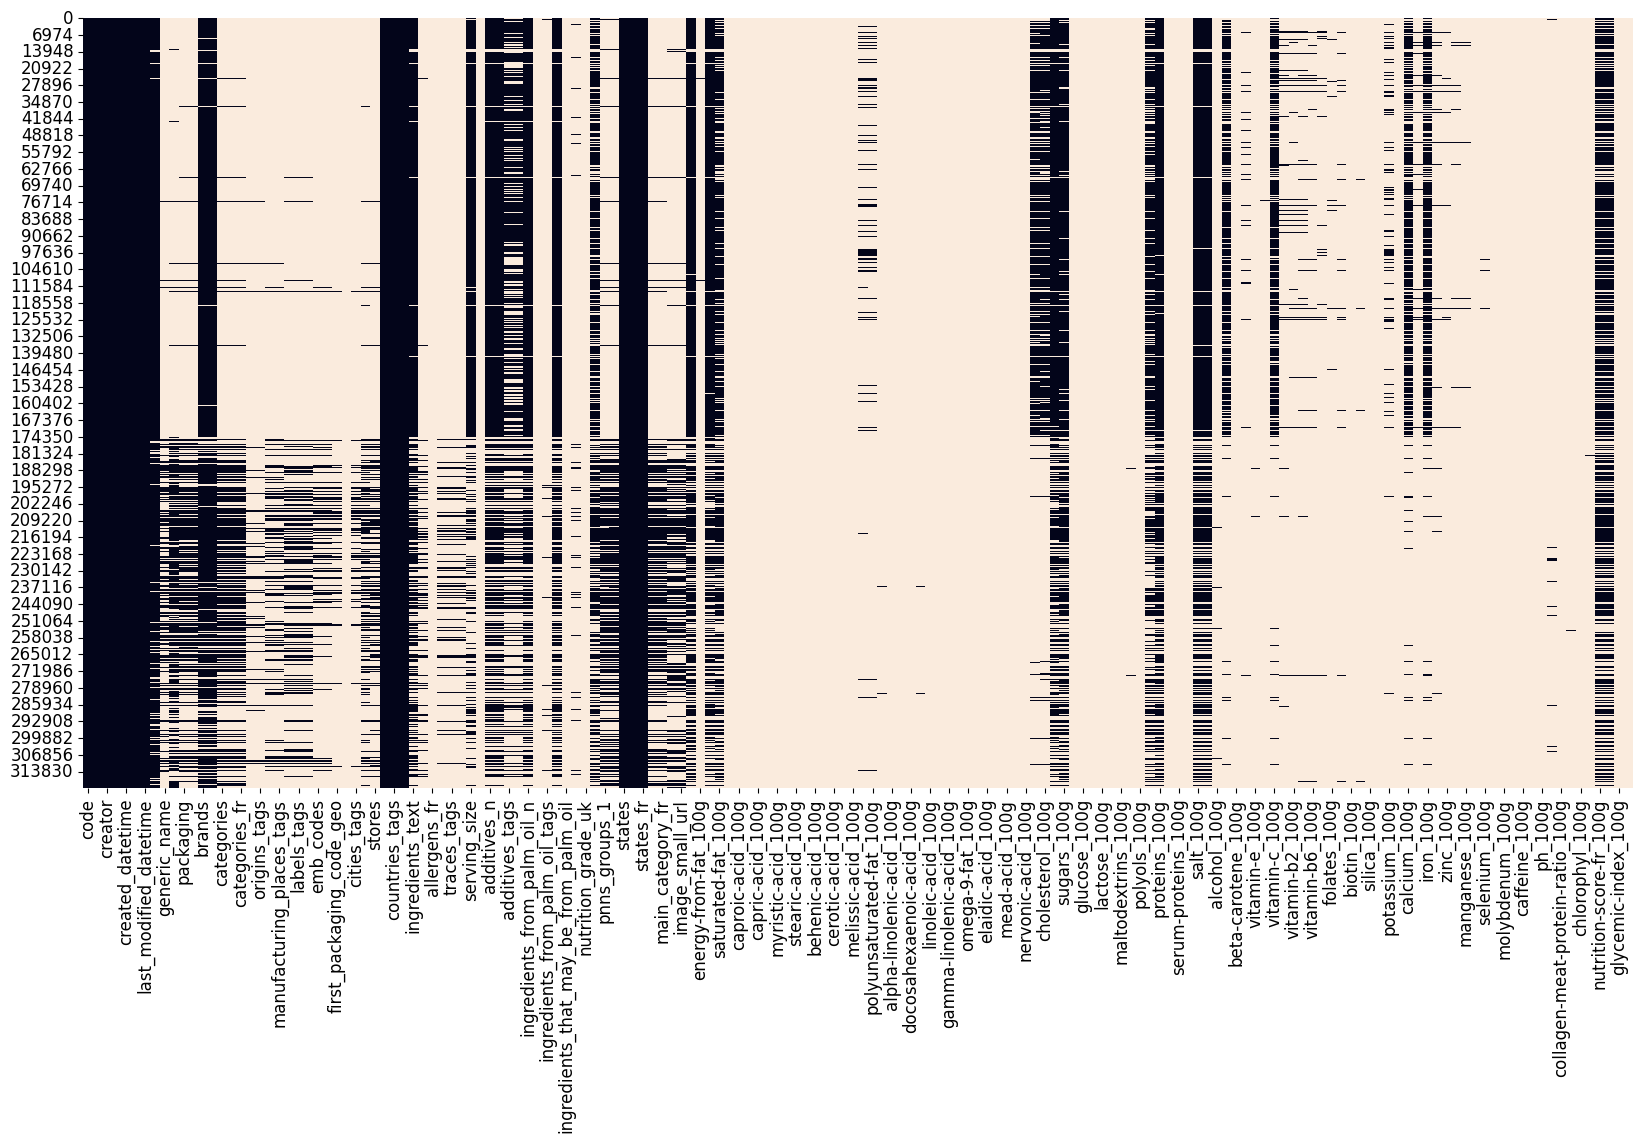

In [1364]:
print("-------------------------------------------------------------")
print("Heatmap de visualisation des valeurs manquantes")
plt.figure(figsize=(20, 10))
sns.heatmap(data.isna(), cbar=False)
plt.show()

### Nettoyage du jeu de donnees

In [1365]:
food = data.copy()

In [1366]:
nb_lignes = food.shape[0]
sum_nan = food.isna().sum()

df_nan = pd.DataFrame({'Variable': sum_nan.index,
                           'nb_nan': sum_nan.values})

df_nan['%_nan'] = [(row * 100) / nb_lignes for row in df_nan['nb_nan']]
df_nan['%_nan_groupe'] = pd.cut(df_nan['%_nan'], bins=[0, 10, 20, 40, 60, 80, 100])
sum_gpe_nan = df_nan['%_nan_groupe'].value_counts().sort_index()

df_group_nan = pd.DataFrame({'Plage de %': sum_gpe_nan.index,
                              'nb_variable': sum_gpe_nan.values})



In [1367]:
df_nan

,Variable,nb_nan,%_nan,%_nan_groupe
0,code,23,0.007170,"(0, 10]"
1,url,23,0.007170,"(0, 10]"
2,creator,2,0.000623,"(0, 10]"
3,created_t,3,0.000935,"(0, 10]"
4,created_datetime,9,0.002806,"(0, 10]"
...,...,...,...,...
157,carbon-footprint_100g,320504,99.916452,"(80, 100]"
158,nutrition-score-fr_100g,99562,31.038245,"(20, 40]"
159,nutrition-score-uk_100g,99562,31.038245,"(20, 40]"
160,glycemic-index_100g,320772,100.000000,"(80, 100]"


In [1368]:
df_group_nan

,Plage de %,nb_variable
0,"(0, 10]",14
1,"(10, 20]",2
2,"(20, 40]",16
3,"(40, 60]",8
4,"(60, 80]",12
5,"(80, 100]",108


#### 108 variables avec plus de 80% de valeurs manquantes.
#### 120 variables avec plus de 60% de valeurs manquantes.
#### Conclusion : la suppression des variables très peu renseignées devra être effectuée.

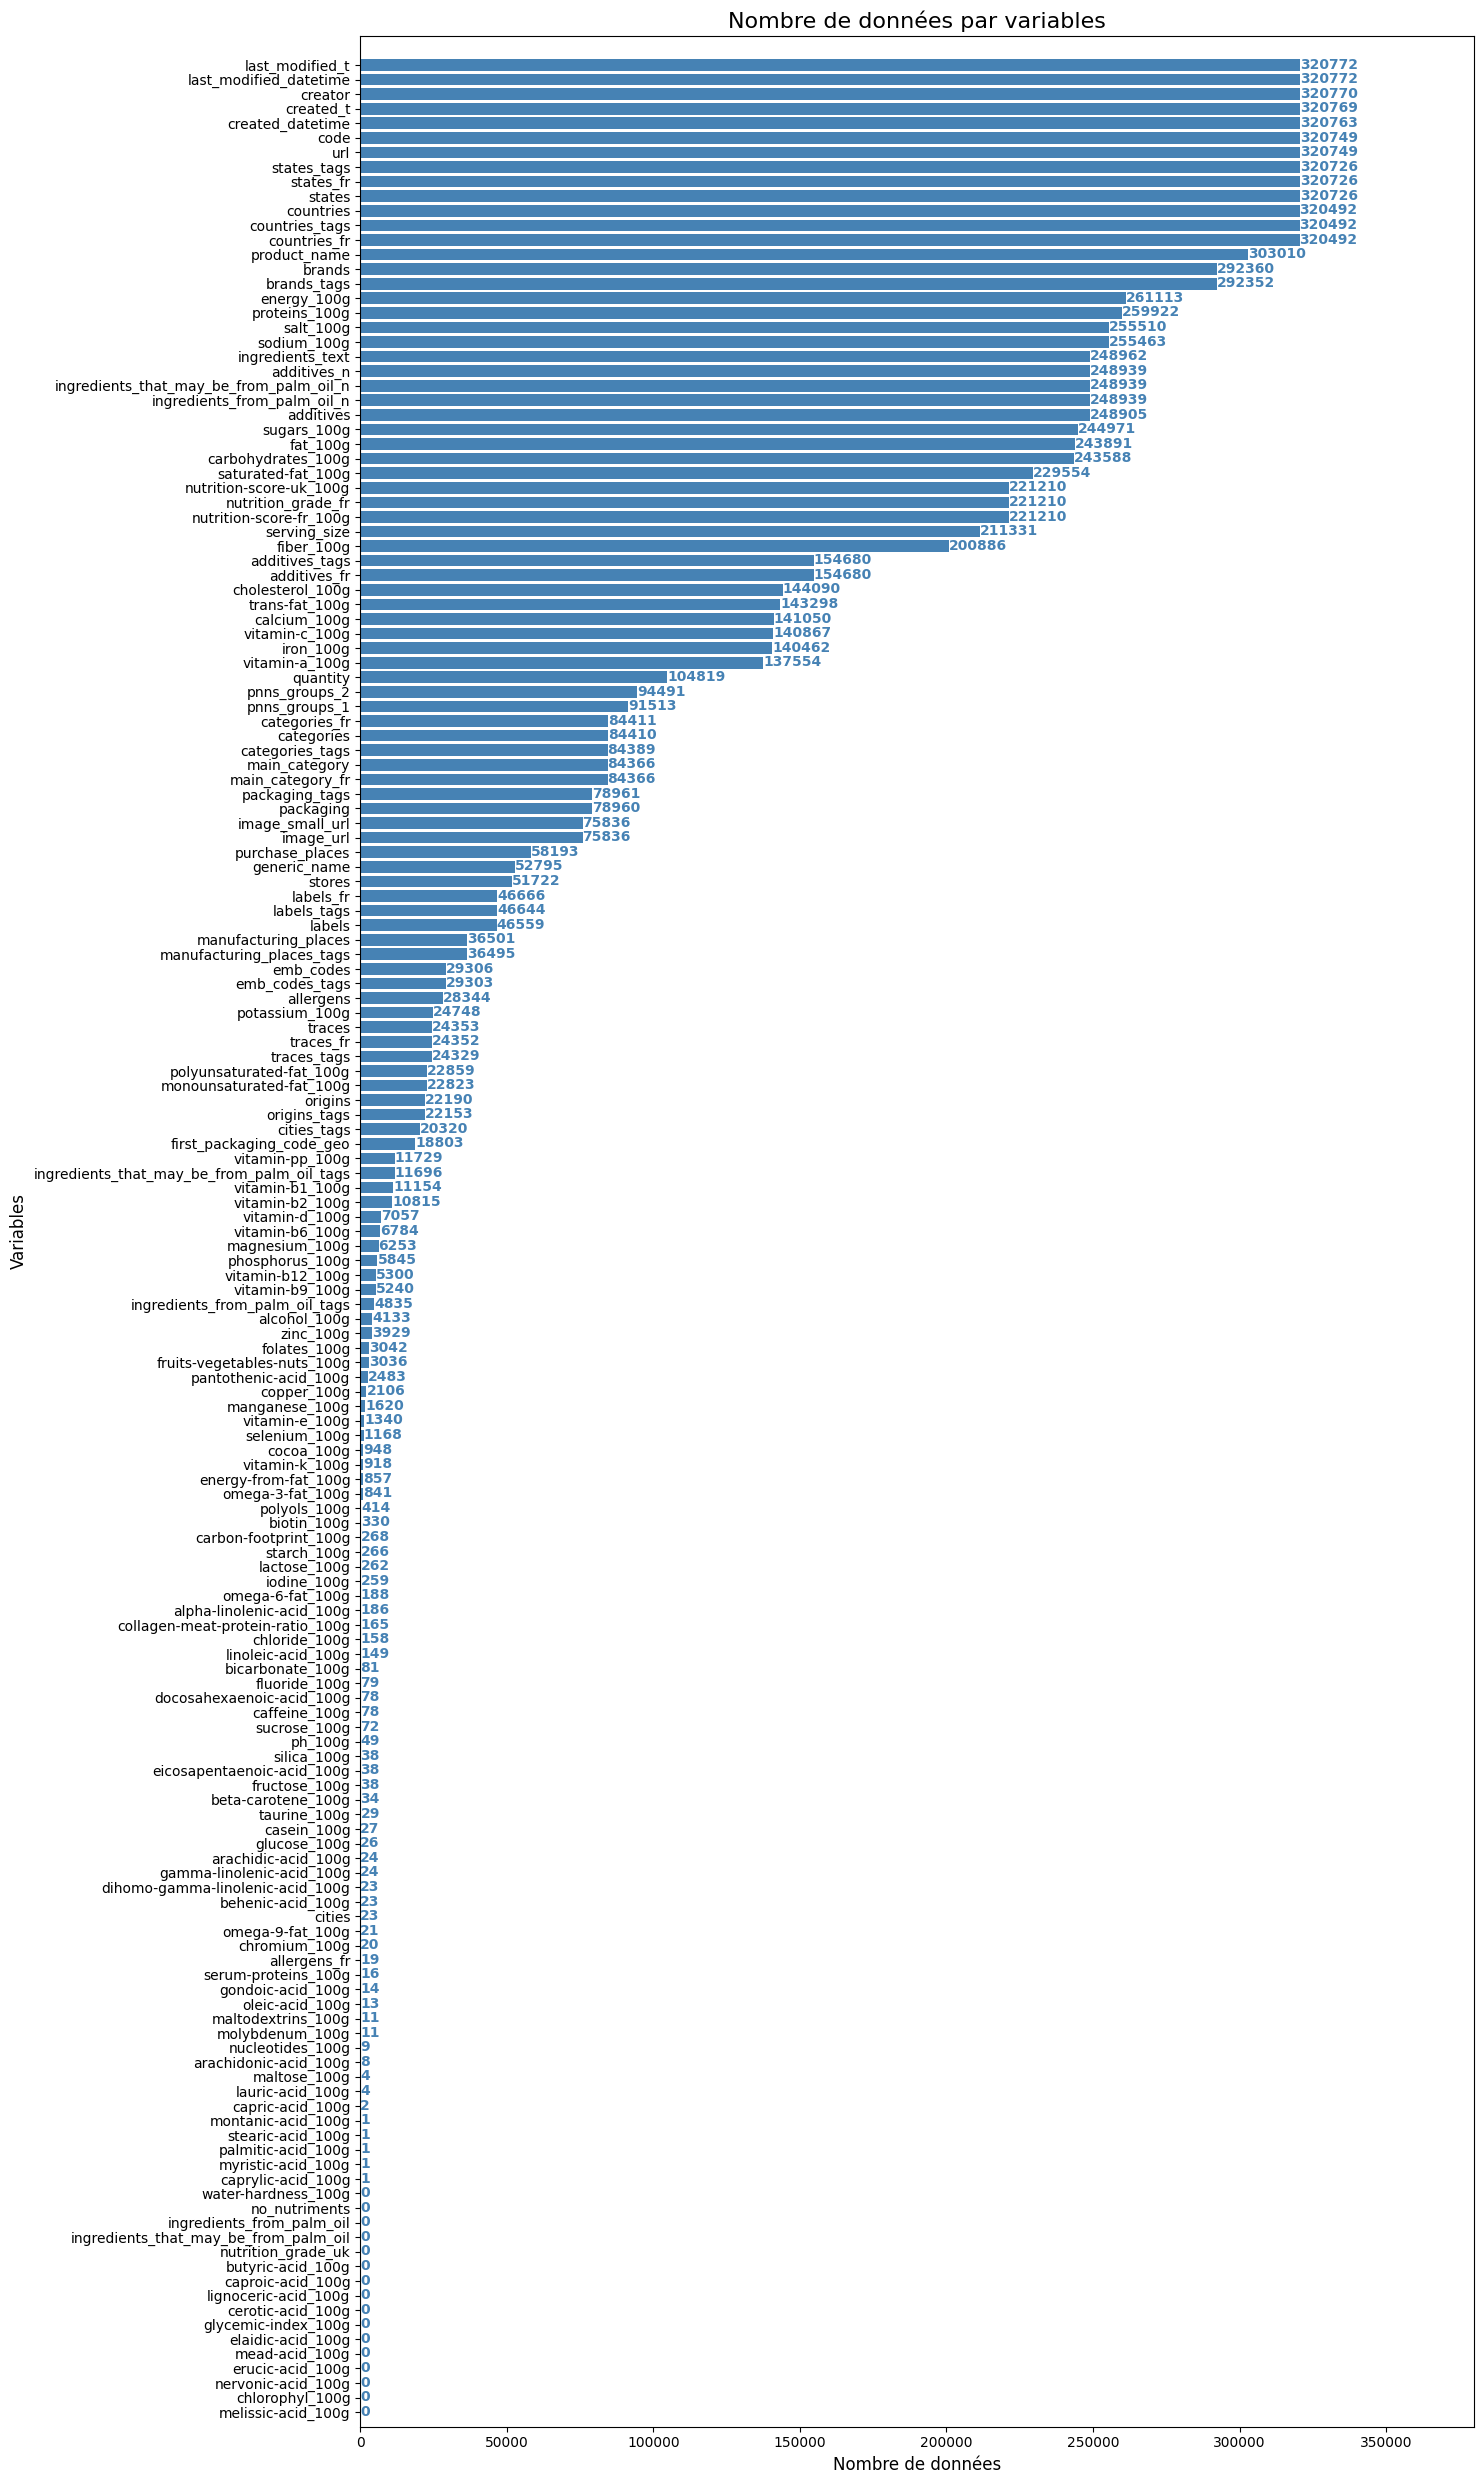

In [1369]:
# Répartition des valeurs renseignées par variables
fig, ax = plt.subplots(figsize=(15, 25))

# Graphique ligne 1, colonne 1 ------------------
# Répartition des valeurs renseignées par variables
present = food.count()
present.sort_values(inplace=True)
ax.barh(y=present.index, width=present.values, color='SteelBlue')
for i, v in enumerate(present):
    ax.text(v + 5, i - .25, str(v), color='SteelBlue',
            fontsize=10, fontweight='bold')
ax.set_title('Nombre de données par variables', fontsize=16)
ax.set_xlabel('Nombre de données', fontsize=12)
ax.set_ylabel('Variables', fontsize=12)
ax.tick_params(labelsize=10)
ax.set_xlim([0, 380000])
ax.set_ylim([-1, 163])
ax.grid(False)
fig.tight_layout()
plt.show()

### Suppression des varibales completement vides

In [1370]:
data_count = food.count()
sum_vide = data_count[data_count == 0]
print(f'Nombre de variables totalements vides : {len(sum_vide)} \n\nListe :')
print(sum_vide.index.tolist())

Nombre de variables totalements vides : 16 

Liste :
['no_nutriments', 'ingredients_from_palm_oil', 'ingredients_that_may_be_from_palm_oil', 'nutrition_grade_uk', 'butyric-acid_100g', 'caproic-acid_100g', 'lignoceric-acid_100g', 'cerotic-acid_100g', 'melissic-acid_100g', 'elaidic-acid_100g', 'mead-acid_100g', 'erucic-acid_100g', 'nervonic-acid_100g', 'chlorophyl_100g', 'glycemic-index_100g', 'water-hardness_100g']


In [1371]:
food.dropna(axis=1, how='all', inplace=True)

In [1372]:
food_shape = food.shape
print(f"Le jeu de donnee contient {food_shape[0]} lignes et {food_shape[1]} colonnes.")

Le jeu de donnee contient 320772 lignes et 146 colonnes.


#### Modification des noms de variables avec un tiret : '-' -> '_'

In [1373]:
car_avant = '-'
car_apres = '_'

cols_a_renommer = food.columns[food.columns.str.contains(car_avant)]
print(f"{len(cols_a_renommer)} variables renommées {car_avant} en {car_apres} : \n\n {cols_a_renommer.tolist()}")

food.columns = food.columns.str.replace(car_avant, car_apres)

45 variables renommées - en _ : 

 ['energy-from-fat_100g', 'saturated-fat_100g', 'caprylic-acid_100g', 'capric-acid_100g', 'lauric-acid_100g', 'myristic-acid_100g', 'palmitic-acid_100g', 'stearic-acid_100g', 'arachidic-acid_100g', 'behenic-acid_100g', 'montanic-acid_100g', 'monounsaturated-fat_100g', 'polyunsaturated-fat_100g', 'omega-3-fat_100g', 'alpha-linolenic-acid_100g', 'eicosapentaenoic-acid_100g', 'docosahexaenoic-acid_100g', 'omega-6-fat_100g', 'linoleic-acid_100g', 'arachidonic-acid_100g', 'gamma-linolenic-acid_100g', 'dihomo-gamma-linolenic-acid_100g', 'omega-9-fat_100g', 'oleic-acid_100g', 'gondoic-acid_100g', 'trans-fat_100g', 'serum-proteins_100g', 'vitamin-a_100g', 'beta-carotene_100g', 'vitamin-d_100g', 'vitamin-e_100g', 'vitamin-k_100g', 'vitamin-c_100g', 'vitamin-b1_100g', 'vitamin-b2_100g', 'vitamin-pp_100g', 'vitamin-b6_100g', 'vitamin-b9_100g', 'vitamin-b12_100g', 'pantothenic-acid_100g', 'fruits-vegetables-nuts_100g', 'collagen-meat-protein-ratio_100g', 'carbon-f

In [1374]:
food.columns.to_list()

['code',
 'url',
 'creator',
 'created_t',
 'created_datetime',
 'last_modified_t',
 'last_modified_datetime',
 'product_name',
 'generic_name',
 'quantity',
 'packaging',
 'packaging_tags',
 'brands',
 'brands_tags',
 'categories',
 'categories_tags',
 'categories_fr',
 'origins',
 'origins_tags',
 'manufacturing_places',
 'manufacturing_places_tags',
 'labels',
 'labels_tags',
 'labels_fr',
 'emb_codes',
 'emb_codes_tags',
 'first_packaging_code_geo',
 'cities',
 'cities_tags',
 'purchase_places',
 'stores',
 'countries',
 'countries_tags',
 'countries_fr',
 'ingredients_text',
 'allergens',
 'allergens_fr',
 'traces',
 'traces_tags',
 'traces_fr',
 'serving_size',
 'additives_n',
 'additives',
 'additives_tags',
 'additives_fr',
 'ingredients_from_palm_oil_n',
 'ingredients_from_palm_oil_tags',
 'ingredients_that_may_be_from_palm_oil_n',
 'ingredients_that_may_be_from_palm_oil_tags',
 'nutrition_grade_fr',
 'pnns_groups_1',
 'pnns_groups_2',
 'states',
 'states_tags',
 'states_fr',


### Filtrer les donnees pertinentes

#### parametres qu'on souhaite conserver : nutriscore / proteines / lipides / glucides / vitamines / mineraux / produits FR / produits peu transformes / noms produits / categories / marques 

In [1375]:
# Information generales, comparaison des colonnes generic_name vs product_name

data_product = food.loc[food['generic_name'] != food['product_name']]
data_product = data_product[['generic_name', 'product_name']][data_product['generic_name'].notnull()]
data_product

,generic_name,product_name
174,Laitue en salade,Salade Cesar
175,Pâtisserie,Danoises à la cannelle roulées
180,Pâtisserie,Chaussons tressés aux pommes
181,Pain,Pain Burger Artisan
184,Biscuits sablés déclassés fourrage au cacao,Biscuits sablés fourrage au cacao
...,...,...
320758,Miel,Miel de Camargue
320761,Vins blanc du Bugey,Roussette du Bugey (2011)
320762,Sprot,Szprot w oleju roslinnym
320763,thé bio équitable,Thé vert Earl grey


#### La variable product_name contient plus d'informations non null que la colonne generic_name, conservation de product_name

In [1376]:
# comparaison des colonnes countries vs countries_fr vs countries_tags

condt_countries = food['countries'] != food['countries_fr']
condt_countries2 = food['countries'] != food['countries_tags']

data_countries = food.loc[condt_countries | condt_countries2]
data_countries = data_countries[['countries', 'countries_fr', 'countries_tags']]
data_countries

,countries,countries_fr,countries_tags
0,en:FR,France,en:france
1,US,États-Unis,en:united-states
2,US,États-Unis,en:united-states
3,US,États-Unis,en:united-states
4,US,États-Unis,en:united-states
...,...,...,...
320767,en:RO,Roumanie,en:romania
320768,US,États-Unis,en:united-states
320769,China,Chine,en:china
320770,en:FR,France,en:france


#### La variable countries_fr contient tous les pays et pas seulement la France, conservation de cette colonne

In [1377]:
# comparaison des colonnes pnns_groups_1 vs pnns_groups_2

data_gpe_product = food.loc[food['pnns_groups_1'] != food['pnns_groups_2']]
data_gpe_product = data_gpe_product[['pnns_groups_1', 'pnns_groups_2']]
data_gpe_product

,pnns_groups_1,pnns_groups_2
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
...,...,...
320767,NaN,NaN
320768,NaN,NaN
320769,Salty snacks,Appetizers
320770,NaN,NaN


In [1378]:
print(data_gpe_product[data_gpe_product.notnull().all(axis=1)])

                pnns_groups_1          pnns_groups_2
174     Fruits and vegetables             Vegetables
175             Sugary snacks     Biscuits and cakes
177      Cereals and potatoes                  Bread
180             Sugary snacks     Biscuits and cakes
182      Cereals and potatoes                Legumes
...                       ...                    ...
320759  Fruits and vegetables                 Fruits
320763              Beverages  Non-sugared beverages
320765         Fish Meat Eggs         Processed meat
320766           Salty snacks                   Nuts
320769           Salty snacks             Appetizers

[68889 rows x 2 columns]


#### pnns_1 represente un groupe et pnns_2 un sous groupe, conservation des 2 parametres

In [1379]:
# comparaison des colonnes brands vs brands_tags

data_brnds = food.loc[food['brands'] != food['brands_tags']]
data_brnds = data_brnds[['brands', 'brands_tags']][data_brnds['brands'].notnull()]
data_brnds

,brands,brands_tags
0,Ferme t'y R'nao,ferme-t-y-r-nao
2,Torn & Glasser,torn-glasser
3,Grizzlies,grizzlies
4,Bob's Red Mill,bob-s-red-mill
5,Unfi,unfi
...,...,...
320765,"Sans marque,D.Lambert","sans-marque,d-lambert"
320767,Panzani,panzani
320768,Trader Joe's,trader-joe-s
320770,Knorr,knorr


#### Le nom de la marque est plus littéraire dans la variable 'brands', conservation de la colonne brands

### Variables retenues : code / image_url / product_name / stores / countries_fr / pnns_groups_1 / pnns_groups_2 / brands

In [1380]:
cols_info_gen = ['code', 'image_url', 'product_name', 'stores', 'countries_fr', 'pnns_groups_1', 'pnns_groups_2', 'brands']

### Variables Alimentaires

In [1381]:
cols_nutriments = food.columns[food.columns.str.endswith('_100g')]
cols_nutriments = cols_nutriments.to_list()
cols_nutriments

['energy_100g',
 'energy_from_fat_100g',
 'fat_100g',
 'saturated_fat_100g',
 'caprylic_acid_100g',
 'capric_acid_100g',
 'lauric_acid_100g',
 'myristic_acid_100g',
 'palmitic_acid_100g',
 'stearic_acid_100g',
 'arachidic_acid_100g',
 'behenic_acid_100g',
 'montanic_acid_100g',
 'monounsaturated_fat_100g',
 'polyunsaturated_fat_100g',
 'omega_3_fat_100g',
 'alpha_linolenic_acid_100g',
 'eicosapentaenoic_acid_100g',
 'docosahexaenoic_acid_100g',
 'omega_6_fat_100g',
 'linoleic_acid_100g',
 'arachidonic_acid_100g',
 'gamma_linolenic_acid_100g',
 'dihomo_gamma_linolenic_acid_100g',
 'omega_9_fat_100g',
 'oleic_acid_100g',
 'gondoic_acid_100g',
 'trans_fat_100g',
 'cholesterol_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'sucrose_100g',
 'glucose_100g',
 'fructose_100g',
 'lactose_100g',
 'maltose_100g',
 'maltodextrins_100g',
 'starch_100g',
 'polyols_100g',
 'fiber_100g',
 'proteins_100g',
 'casein_100g',
 'serum_proteins_100g',
 'nucleotides_100g',
 'salt_100g',
 'sodium_100g',
 'alco

In [1382]:
# comparaison colonnes nutrition_score_fr_100g vs nutrition_score_uk_100g

data_nutrition_scrore = food.loc[food['nutrition_score_fr_100g'] != food['nutrition_score_uk_100g']]
data_nutrition_scrore = data_nutrition_scrore[['nutrition_score_fr_100g', 'nutrition_score_uk_100g']]
data_nutrition_scrore

,nutrition_score_fr_100g,nutrition_score_uk_100g
0,NaN,NaN
4,NaN,NaN
5,NaN,NaN
6,NaN,NaN
8,NaN,NaN
...,...,...
320766,NaN,NaN
320767,NaN,NaN
320769,NaN,NaN
320770,NaN,NaN


In [1383]:
print(data_nutrition_scrore[data_nutrition_scrore.notnull().all(axis=1)])

        nutrition_score_fr_100g  nutrition_score_uk_100g
226                        13.0                      2.0
240                        13.0                      2.0
648                        11.0                     20.0
664                        12.0                      1.0
695                        14.0                     19.0
...                         ...                      ...
320626                     13.0                      2.0
320629                     14.0                      0.0
320656                     16.0                     20.0
320668                      4.0                     -3.0
320763                      2.0                      0.0

[8322 rows x 2 columns]


#### Peu d'informations presentes. les valeurs nutriscore ne correpondent pas suivant le pays, conservation des deux colonnes

In [1384]:
# comparaison colonnes additives

condt_additives = food['additives'] != food['additives_fr']
condt_additives2 = food['additives'] != food['additives_tags']

data_additives = food.loc[condt_additives | condt_additives2]
data_additives = data_additives[['additives', 'additives_fr', 'additives_tags']][data_additives['additives_fr'].notnull()]
data_additives

,additives,additives_fr,additives_tags
7,[ org-oats -> en:org-oats ] [ oats -> en:oa...,"E123 - Amarante,E307a - Tocophérol","en:e123,en:e307a"
12,[ roasted-peanuts -> en:roasted-peanuts ] [...,E100 - Curcumine,en:e100
21,[ chocolate-stars -> en:chocolate-stars ] [...,E322 - Lécithines,en:e322
23,[ dry-roasted-almonds -> en:dry-roasted-almon...,"E339iii - Phosphate de sodium tribasique,E330 ...","en:e339iii,en:e330"
24,[ peanut-butter -> en:peanut-butter ] [ but...,"E170 - Carbonate de calcium,E322 - Lécithines,...","en:e170,en:e322,en:e410"
...,...,...,...
320708,[ purified-water -> en:purified-water ] [ w...,"E500ii - Hydrogénocarbonate de sodium,E333 - C...","en:e500ii,en:e333,en:e508,en:e530"
320730,[ organic-wheat-flour -> en:organic-wheat-flo...,"E422 - Glycérol,E330 - Acide citrique,E296 - A...","en:e422,en:e330,en:e296"
320738,[ organic-oat-blend -> en:organic-oat-blend ...,E322 - Lécithines,en:e322
320750,[ water -> en:water ] [ high-fructose-corn-...,"E330 - Acide citrique,E440 - Pectines,E331 - C...","en:e330,en:e440,en:e331,en:e150a,en:e201,en:e1..."


#### on retrouve tous les additifs alimentaire. la colonnes 'additives_fr' semble plus adaptes, conservation de cette colonne.

### Variables Alimentations Saines

In [1385]:
cols_alim_saine = ['additives_n', 'additives_fr', 'ingredients_from_palm_oil_n',
                   'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil_n',
                   'ingredients_that_may_be_from_palm_oil_tags', 'nutrition_grade_fr', 'allergens']

In [1386]:
cols_a_garder = cols_info_gen + cols_nutriments + cols_alim_saine
cols_a_garder

['code',
 'image_url',
 'product_name',
 'stores',
 'countries_fr',
 'pnns_groups_1',
 'pnns_groups_2',
 'brands',
 'energy_100g',
 'energy_from_fat_100g',
 'fat_100g',
 'saturated_fat_100g',
 'caprylic_acid_100g',
 'capric_acid_100g',
 'lauric_acid_100g',
 'myristic_acid_100g',
 'palmitic_acid_100g',
 'stearic_acid_100g',
 'arachidic_acid_100g',
 'behenic_acid_100g',
 'montanic_acid_100g',
 'monounsaturated_fat_100g',
 'polyunsaturated_fat_100g',
 'omega_3_fat_100g',
 'alpha_linolenic_acid_100g',
 'eicosapentaenoic_acid_100g',
 'docosahexaenoic_acid_100g',
 'omega_6_fat_100g',
 'linoleic_acid_100g',
 'arachidonic_acid_100g',
 'gamma_linolenic_acid_100g',
 'dihomo_gamma_linolenic_acid_100g',
 'omega_9_fat_100g',
 'oleic_acid_100g',
 'gondoic_acid_100g',
 'trans_fat_100g',
 'cholesterol_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'sucrose_100g',
 'glucose_100g',
 'fructose_100g',
 'lactose_100g',
 'maltose_100g',
 'maltodextrins_100g',
 'starch_100g',
 'polyols_100g',
 'fiber_100g',


In [1387]:
data_retained = food[cols_a_garder]

In [1388]:
data_retained_shape = data_retained.shape
print(f"Le jeu de donnee contient {data_retained_shape[0]} lignes et {data_retained_shape[1]} colonnes.")

Le jeu de donnee contient 320772 lignes et 103 colonnes.


## Visualisation des valeurs manquantes

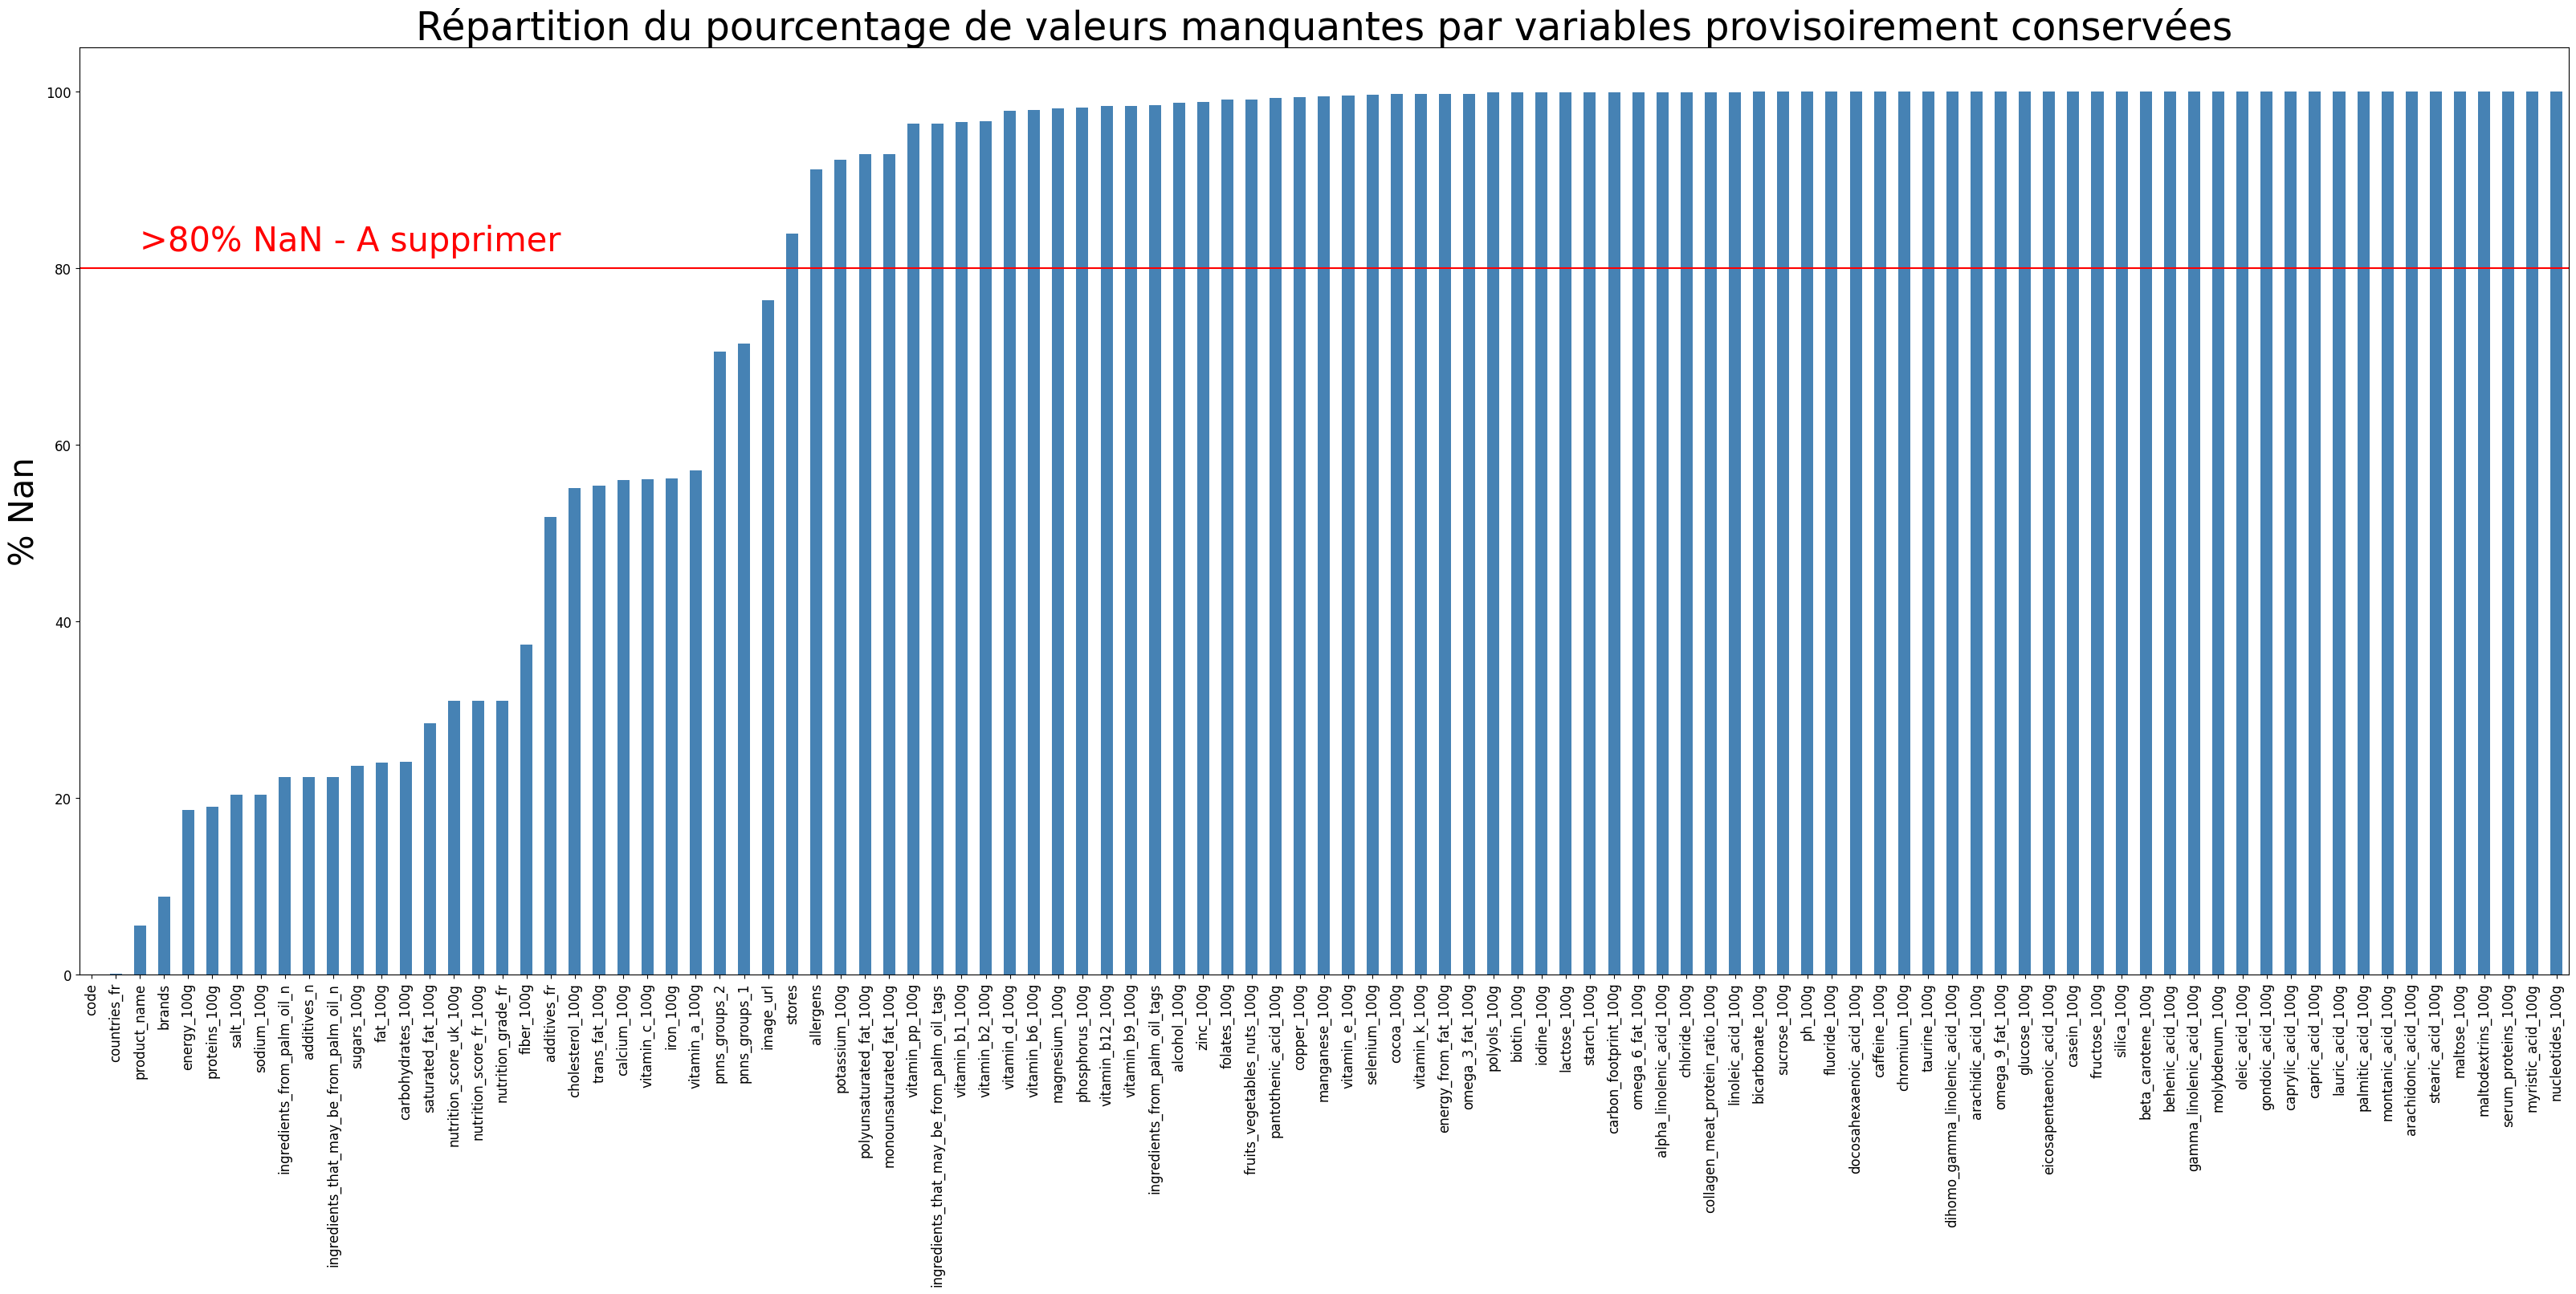

In [1389]:
# Répartition du pourcentage de valeurs manquantes pour toutes les variables provisoirement conservées
plt.figure(figsize=(40, 15))
data_retained_nan = round((data_retained.isna().sum()/data_retained.shape[0]) * 100, 2)
data_retained_nan.sort_values(inplace=True)
data_retained_nan.plot(kind='bar', color='SteelBlue')
plt.title('Répartition du pourcentage de valeurs manquantes par variables provisoirement conservées', fontsize=35)
plt.ylabel('% Nan', fontsize=30)
plt.axhline(y=80, color='r')
plt.text(2, 82, '>80% NaN - A supprimer', color='r', fontsize=30)
plt.show()

## Constitution du jeu de donnees de travail

In [1390]:
data_work_nan = round((data_retained.isna().sum() / data_retained.shape[0]) * 100, 2)
cols = data_retained.columns.tolist()

# Conservation seulement des variables avec valeurs manquantes >= 80%
seuil = 80
cols_a_garder = data_work_nan[data_work_nan.values < seuil].index.tolist()

cols_info_gen_supprimees = [col for col in cols if col not in cols_a_garder]

data_retained = data_retained[cols_a_garder]

print(f'Liste des variables éliminées :\n{cols_info_gen_supprimees}\n')
print(f'Liste des variables conservées :\n{cols_a_garder}')

Liste des variables éliminées :
['stores', 'energy_from_fat_100g', 'caprylic_acid_100g', 'capric_acid_100g', 'lauric_acid_100g', 'myristic_acid_100g', 'palmitic_acid_100g', 'stearic_acid_100g', 'arachidic_acid_100g', 'behenic_acid_100g', 'montanic_acid_100g', 'monounsaturated_fat_100g', 'polyunsaturated_fat_100g', 'omega_3_fat_100g', 'alpha_linolenic_acid_100g', 'eicosapentaenoic_acid_100g', 'docosahexaenoic_acid_100g', 'omega_6_fat_100g', 'linoleic_acid_100g', 'arachidonic_acid_100g', 'gamma_linolenic_acid_100g', 'dihomo_gamma_linolenic_acid_100g', 'omega_9_fat_100g', 'oleic_acid_100g', 'gondoic_acid_100g', 'sucrose_100g', 'glucose_100g', 'fructose_100g', 'lactose_100g', 'maltose_100g', 'maltodextrins_100g', 'starch_100g', 'polyols_100g', 'casein_100g', 'serum_proteins_100g', 'nucleotides_100g', 'alcohol_100g', 'beta_carotene_100g', 'vitamin_d_100g', 'vitamin_e_100g', 'vitamin_k_100g', 'vitamin_b1_100g', 'vitamin_b2_100g', 'vitamin_pp_100g', 'vitamin_b6_100g', 'vitamin_b9_100g', 'fola

In [1391]:
data_retained.shape

(320772, 29)

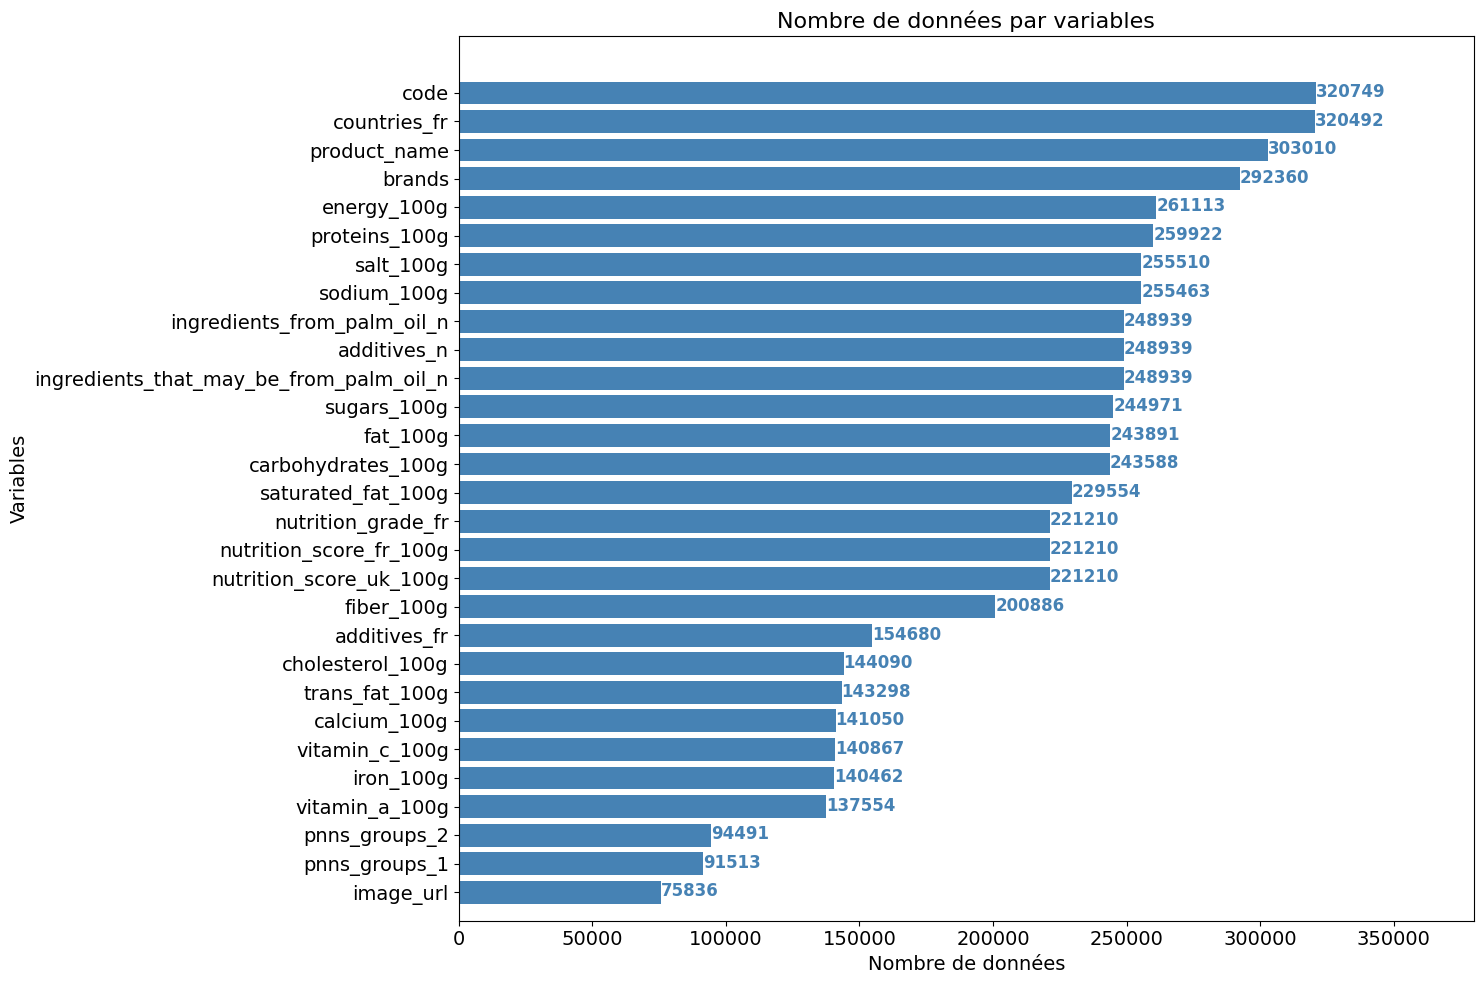

In [1392]:
# Répartition des valeurs renseignées par variables
fig, ax = plt.subplots(figsize=(15, 10))

# Graphique ligne 1, colonne 1 ------------------
# Répartition des valeurs renseignées par variables
present = data_retained.count()
present.sort_values(inplace=True)
ax.barh(y=present.index, width=present.values, color='SteelBlue')
for i, v in enumerate(present):
    ax.text(v + 5, i - .15, str(v), color='SteelBlue',
            fontsize=12, fontweight='bold')
ax.set_title('Nombre de données par variables', fontsize=16)
ax.set_xlabel('Nombre de données', fontsize=14)
ax.set_ylabel('Variables', fontsize=14)
ax.tick_params(labelsize=14)
ax.set_xlim([0, 380000])
ax.set_ylim([-1, 30])
ax.grid(False)

fig.tight_layout()
plt.show()

### Modification des types de variables

In [1393]:
data_retained.dtypes

code                                        object
image_url                                   object
product_name                                object
countries_fr                                object
pnns_groups_1                               object
pnns_groups_2                               object
brands                                      object
energy_100g                                float64
fat_100g                                   float64
saturated_fat_100g                         float64
trans_fat_100g                             float64
cholesterol_100g                           float64
carbohydrates_100g                         float64
sugars_100g                                float64
fiber_100g                                 float64
proteins_100g                              float64
salt_100g                                  float64
sodium_100g                                float64
vitamin_a_100g                             float64
vitamin_c_100g                 

#### transformation des types object en category si le nombre ede modalite est inf au nombre de ligne

In [1394]:
for col in data_retained.columns.values:
    if data_retained[col].dtype == 'object':
        #print(data_retained[col].unique())
        print('Colonne : ', col)
        if len(data_retained[col].unique()) / len(data_retained[col]) < 0.5:
            data_retained[col] = data_retained[col].astype('category')

Colonne :  code
Colonne :  image_url
Colonne :  product_name
Colonne :  countries_fr
Colonne :  pnns_groups_1
Colonne :  pnns_groups_2
Colonne :  brands
Colonne :  additives_fr
Colonne :  nutrition_grade_fr


In [1395]:
data_retained.dtypes

code                                         object
image_url                                  category
product_name                                 object
countries_fr                               category
pnns_groups_1                              category
pnns_groups_2                              category
brands                                     category
energy_100g                                 float64
fat_100g                                    float64
saturated_fat_100g                          float64
trans_fat_100g                              float64
cholesterol_100g                            float64
carbohydrates_100g                          float64
sugars_100g                                 float64
fiber_100g                                  float64
proteins_100g                               float64
salt_100g                                   float64
sodium_100g                                 float64
vitamin_a_100g                              float64
vitamin_c_10

### Suppression des produits sans noms

In [1396]:
data_retained.dropna(subset=['product_name'], inplace=True)

In [1397]:
data_retained_shape = data_retained.shape
print(f"Le jeu de donnee contient {data_retained_shape[0]} lignes et {data_retained_shape[1]} colonnes.")

Le jeu de donnee contient 303010 lignes et 29 colonnes.


### Conservation des produits FR uniquement

In [1398]:
data_retained.loc[data_retained['countries_fr'] == 'France', :]

,code,image_url,product_name,countries_fr,pnns_groups_1,pnns_groups_2,brands,energy_100g,fat_100g,saturated_fat_100g,...,vitamin_c_100g,calcium_100g,iron_100g,nutrition_score_fr_100g,nutrition_score_uk_100g,additives_n,additives_fr,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutrition_grade_fr
0,0000000003087,NaN,Farine de blé noir,France,NaN,NaN,Ferme t'y R'nao,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,0000000024600,http://fr.openfoodfacts.org/images/products/00...,Filet de bœuf,France,unknown,unknown,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
136,0000000039259,http://fr.openfoodfacts.org/images/products/00...,Twix x2,France,unknown,unknown,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
182,0000005200016,http://fr.openfoodfacts.org/images/products/00...,lentilles vertes,France,Cereals and potatoes,Legumes,Bertrand Lejeune,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
184,0000007730009,http://fr.openfoodfacts.org/images/products/00...,Biscuits sablés fourrage au cacao,France,Sugary snacks,Biscuits and cakes,St Michel,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3.0,"E1400 - Dextrines,E322 - Lécithines,E503 - Car...",0.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320761,9906410000009,http://fr.openfoodfacts.org/images/products/99...,Roussette du Bugey (2011),France,NaN,Alcoholic beverages,Roussette du Bugey,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
320763,99111250,http://fr.openfoodfacts.org/images/products/99...,Thé vert Earl grey,France,Beverages,Non-sugared beverages,Lobodis,21.0,0.2,0.2,...,NaN,NaN,NaN,2.0,0.0,0.0,NaN,0.0,0.0,c
320764,9918,http://fr.openfoodfacts.org/images/products/99...,"Cheese cake thé vert, yuzu",France,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
320765,9935010000003,http://fr.openfoodfacts.org/images/products/99...,Rillette d'oie,France,Fish Meat Eggs,Processed meat,"Sans marque,D.Lambert",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN


In [1399]:
data_retained.countries_fr.unique().to_list()

['France',
 'États-Unis',
 'Royaume-Uni',
 'France,États-Unis',
 'Canada',
 'Suisse',
 'Espagne',
 'Allemagne',
 'Slovénie',
 'Italie',
 'Roumanie',
 'Australie',
 'France,Royaume-Uni',
 'Belgique,France,Pays-Bas,Royaume-Uni',
 'Guadeloupe',
 'Royaume-Uni,États-Unis',
 'Canada,États-Unis',
 'Pays-Bas',
 'Australie,France',
 'Canada,France,Suisse,États-Unis',
 'France,États-Unis,en:Etats-unis',
 'Irlande',
 'France,La Réunion',
 'Australie,Suisse',
 'France,Allemagne',
 'Brésil',
 'Belgique,France',
 'États-Unis,en:Australie',
 'Arabie saoudite',
 'Émirats arabes unis',
 'Moldavie',
 'Belgique',
 nan,
 'Singapour',
 'Finlande',
 'Australie,États-Unis',
 'France,Suisse',
 'Australie,Nouvelle-Zélande,Singapour,Thaïlande,États-Unis',
 'Panama',
 'Costa Rica',
 'États-Unis,en:Pays-bas',
 'Espagne,Royaume-Uni,en:Scotland',
 'Thaïlande',
 'Mexique',
 'Chine',
 'Luxembourg',
 'Liban',
 'Suisse,États-Unis',
 'États-Unis,en:Deutschland',
 'France,Suisse,États-Unis',
 'Belgique,Suisse,États-Unis'

In [1400]:
data_retained = data_retained.loc[data_retained['countries_fr'] == 'France']

In [1401]:
data_retained_shape = data_retained.shape
print(f"Le jeu de donnee contient {data_retained_shape[0]} lignes et {data_retained_shape[1]} colonnes.")

Le jeu de donnee contient 87398 lignes et 29 colonnes.


In [1402]:
data_retained

,code,image_url,product_name,countries_fr,pnns_groups_1,pnns_groups_2,brands,energy_100g,fat_100g,saturated_fat_100g,...,vitamin_c_100g,calcium_100g,iron_100g,nutrition_score_fr_100g,nutrition_score_uk_100g,additives_n,additives_fr,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutrition_grade_fr
0,0000000003087,NaN,Farine de blé noir,France,NaN,NaN,Ferme t'y R'nao,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,0000000024600,http://fr.openfoodfacts.org/images/products/00...,Filet de bœuf,France,unknown,unknown,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
136,0000000039259,http://fr.openfoodfacts.org/images/products/00...,Twix x2,France,unknown,unknown,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
182,0000005200016,http://fr.openfoodfacts.org/images/products/00...,lentilles vertes,France,Cereals and potatoes,Legumes,Bertrand Lejeune,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
184,0000007730009,http://fr.openfoodfacts.org/images/products/00...,Biscuits sablés fourrage au cacao,France,Sugary snacks,Biscuits and cakes,St Michel,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3.0,"E1400 - Dextrines,E322 - Lécithines,E503 - Car...",0.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320761,9906410000009,http://fr.openfoodfacts.org/images/products/99...,Roussette du Bugey (2011),France,NaN,Alcoholic beverages,Roussette du Bugey,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
320763,99111250,http://fr.openfoodfacts.org/images/products/99...,Thé vert Earl grey,France,Beverages,Non-sugared beverages,Lobodis,21.0,0.2,0.2,...,NaN,NaN,NaN,2.0,0.0,0.0,NaN,0.0,0.0,c
320764,9918,http://fr.openfoodfacts.org/images/products/99...,"Cheese cake thé vert, yuzu",France,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
320765,9935010000003,http://fr.openfoodfacts.org/images/products/99...,Rillette d'oie,France,Fish Meat Eggs,Processed meat,"Sans marque,D.Lambert",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN


### Groupe de produit

In [1403]:
# Remplacement des tirets '-' par un esapce simple
data_retained['pnns_groups_1'] = data_retained['pnns_groups_1'].str.replace('-', " ")

In [1404]:
# Normaliser tout en minuscule
data_retained['pnns_groups_1'] = data_retained['pnns_groups_1'].str.lower().apply(str)

In [1405]:
data_retained['pnns_groups_1'].sort_values().unique().tolist()

['beverages',
 'cereals and potatoes',
 'composite foods',
 'fat and sauces',
 'fish meat eggs',
 'fruits and vegetables',
 'milk and dairy products',
 'nan',
 'salty snacks',
 'sugary snacks',
 'unknown']

In [1406]:
# Traduction de certains nom de groupe en Francais
dico_trad_grp1 = {'beverages': 'boissons',
                  'cereals and potatoes': 'cereales et pommes de terre',
                  'composite foods': 'aliments composes',
                  'fat and sauces': 'matieres grasses et les sauces',
                  'fish meat eggs': 'poisson viande oeufs',
                  'fruits and vegetables': 'fruits et legumes',
                  'milk and dairy products': 'lait et les produits laitiers',
                  'nan': 'a renseigner',
                  'salty snacks': 'collation sales',
                  'sugary snacks': 'collation sucree',
                  'unknown': 'a renseigner'}

for cle, valeur in dico_trad_grp1.items():
    data_retained['pnns_groups_1'] = data_retained['pnns_groups_1'].replace(cle, valeur)

In [1407]:
data_retained['pnns_groups_1'].sort_values().unique().tolist()

['a renseigner',
 'aliments composes',
 'boissons',
 'cereales et pommes de terre',
 'collation sales',
 'collation sucree',
 'fruits et legumes',
 'lait et les produits laitiers',
 'matieres grasses et les sauces',
 'poisson viande oeufs']

In [1408]:
# Meme chose pour le sous groupe de produit pnns_groups_2
data_retained['pnns_groups_2'] = data_retained['pnns_groups_2'].str.replace('-', " ")

In [1409]:
data_retained['pnns_groups_2'] = data_retained['pnns_groups_2'].str.lower().apply(str)

In [1410]:
data_retained['pnns_groups_2'].sort_values().unique().tolist()

['alcoholic beverages',
 'appetizers',
 'artificially sweetened beverages',
 'biscuits and cakes',
 'bread',
 'breakfast cereals',
 'cereals',
 'cheese',
 'chocolate products',
 'dairy desserts',
 'dressings and sauces',
 'dried fruits',
 'eggs',
 'fats',
 'fish and seafood',
 'fruit juices',
 'fruit nectars',
 'fruits',
 'ice cream',
 'legumes',
 'meat',
 'milk and yogurt',
 'nan',
 'non sugared beverages',
 'nuts',
 'one dish meals',
 'pastries',
 'pizza pies and quiche',
 'potatoes',
 'processed meat',
 'salty and fatty products',
 'sandwich',
 'soups',
 'sweetened beverages',
 'sweets',
 'tripe dishes',
 'unknown',
 'vegetables']

In [1411]:
dico_trad_grp2 = {'alcoholic beverages': 'boissons alcoolisees',
                  'appetizers': 'aperitifs',
                  'artificially sweetened beverages': 'boissons sucrees artificiellement',
                  'biscuits and cakes': 'biscuits et gateaux',
                  'bread': 'pain',
                  'breakfast cereals': 'cereales pour le petit dejeuner',
                  'cereals': 'cereales',
                  'cheese': 'fromage',
                  'chocolate products': 'produits a base de chocolat',
                  'dairy desserts': 'desserts laitiers',
                  'dressings and sauces': 'vinaigrettes et sauces',
                  'dried fruits': 'fruits secs',
                  'eggs': 'oeufs',
                  'fats': 'matieres grasses',
                  'fish and seafood': 'poissons et fruits de mer',
                  'fruit juices': 'jus de fruits',
                  'fruit nectars': 'nectars de fruits',
                  'ice cream': 'glaces',
                  'legumes': 'legumineuses',
                  'meat': 'viande',
                  'milk and yogurt': 'lait et yaourt',
                  'nan': 'a renseigner',
                  'nuts': 'noix',
                  'offals': 'abats',
                  'one-dish meals': 'repas a un plat',
                  'pastries': 'patisseries',
                  'pizza pies and quiches': 'pizzas et quiches',
                  'plant-based milk substitutes': 'substituts de lait a base de plantes',
                  'potatoes': 'pommes de terre',
                  'processed meat': 'viande transformee',
                  'salty and fatty products': 'produits sales et gras',
                  'sandwiches': 'sandwiches',
                  'soups': 'soupes',
                  'sweetened beverages': 'boissons sucrees',
                  'sweets': 'sucreries',
                  'teas and herbal teas and coffees': 'thes tisanes cafes',
                  'unsweetened beverages': 'boissons non sucrees',
                  'vegetables': 'legumes',
                  'waters and flavored waters': 'eaux et eaux aromatisees',
                  'unknown': 'a renseigner'}

for cle, val in dico_trad_grp2.items():
    data_retained['pnns_groups_2'] = data_retained['pnns_groups_2'].replace(cle, val)

In [1412]:
data_retained['pnns_groups_2'].sort_values().unique().tolist()

['a renseigner',
 'aperitifs',
 'biscuits et gateaux',
 'boissons alcoolisees',
 'boissons sucrees',
 'boissons sucrees artificiellement',
 'cereales',
 'cereales pour le petit dejeuner',
 'desserts laitiers',
 'fromage',
 'fruits',
 'fruits secs',
 'glaces',
 'jus de fruits',
 'lait et yaourt',
 'legumes',
 'legumineuses',
 'matieres grasses',
 'nectars de fruits',
 'noix',
 'non sugared beverages',
 'oeufs',
 'one dish meals',
 'pain',
 'patisseries',
 'pizza pies and quiche',
 'poissons et fruits de mer',
 'pommes de terre',
 'produits a base de chocolat',
 'produits sales et gras',
 'sandwich',
 'soupes',
 'sucreries',
 'tripe dishes',
 'viande',
 'viande transformee',
 'vinaigrettes et sauces']

### Valeurs aberrantes

In [1413]:
# Info generales
data_taille = data_retained.shape[0]
desc_var = data_retained.describe(include='all')

desc_type = pd.DataFrame(desc_var.dtypes, columns=['type']).T
nb_nan = data_taille - desc_var.loc['count'].T
pourcentage_nan = nb_nan * 100 / data_taille
desc_nan = pd.DataFrame([nb_nan, pourcentage_nan],
                        index=['nb_nan', '%_nan'])
desc_var = pd.concat([desc_type, desc_nan, desc_var])
desc_var

,code,image_url,product_name,countries_fr,pnns_groups_1,pnns_groups_2,brands,energy_100g,fat_100g,saturated_fat_100g,...,vitamin_c_100g,calcium_100g,iron_100g,nutrition_score_fr_100g,nutrition_score_uk_100g,additives_n,additives_fr,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutrition_grade_fr
type,object,object,object,object,object,object,object,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,object,float64,float64,object
nb_nan,0.0,40324.0,0.0,0.0,0.0,0.0,5727.0,26280.0,43102.0,28309.0,...,86318.0,85496.0,86486.0,29194.0,29194.0,36958.0,58771.0,36958.0,36958.0,29194.0
%_nan,0.0,46.138356,0.0,0.0,0.0,0.0,6.552782,30.069338,49.316918,32.390901,...,98.764274,97.823749,98.956498,33.40351,33.40351,42.287009,67.245246,42.287009,42.287009,33.40351
count,87398,47074,87398,87398,87398,87398,81671,61118.0,44296.0,59089.0,...,1080.0,1902.0,912.0,58204.0,58204.0,50440.0,28627,50440.0,50440.0,58204
unique,87398,47074,71447,1,10,37,19932,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,10977,NaN,NaN,5
top,0000000003087,http://fr.openfoodfacts.org/images/products/00...,Huile d'olive vierge extra,France,a renseigner,a renseigner,Carrefour,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,E322 - Lécithines,NaN,NaN,d
freq,1,1,59,87398,37879,35953,2734,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1486,NaN,NaN,16099
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1167.388108,13.279629,5.387408,...,0.14708,0.342511,0.051352,8.598155,8.288795,1.857454,NaN,0.067982,0.148434,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13191.50336,16.994811,8.545775,...,3.068464,1.875164,0.852777,9.016808,9.352659,2.569277,NaN,0.255547,0.45228,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,-15.0,-15.0,0.0,NaN,0.0,0.0,NaN


#### Nutrition score FR 100g / Nutrition score UK  100g comportent des valeurs negatives
#### les variables en g pour 100g  de produits depassent les 100g

In [1414]:
data_retained.columns.unique().tolist()

['code',
 'image_url',
 'product_name',
 'countries_fr',
 'pnns_groups_1',
 'pnns_groups_2',
 'brands',
 'energy_100g',
 'fat_100g',
 'saturated_fat_100g',
 'trans_fat_100g',
 'cholesterol_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g',
 'vitamin_a_100g',
 'vitamin_c_100g',
 'calcium_100g',
 'iron_100g',
 'nutrition_score_fr_100g',
 'nutrition_score_uk_100g',
 'additives_n',
 'additives_fr',
 'ingredients_from_palm_oil_n',
 'ingredients_that_may_be_from_palm_oil_n',
 'nutrition_grade_fr']

### Axe sur les variables quantitatives (_100g)

In [1415]:
# fonction pour visualiser au mieux les variables quantitatives avec une box plot

def box_plot(dataframe, variable, title, y_upper_lower_zoom, y_upper_up_zoom, y_lower_zoom, y_lower_up_zoom, unite, lower_limit, upper_limit):

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    sns.boxplot(data=dataframe[variable], color='SteelBlue')
    plt.title(title)

    plt.ylabel(unite + '/100g ou 100ml')
    plt.xlabel = ''
    plt.axhline(y=upper_limit, color='r')
    plt.axhline(y=lower_limit, color='r')

    plt.subplot(1, 3, 2)
    sns.boxplot(data=dataframe[variable], color='SteelBlue')
    plt.title(title + ' zoom')
    plt.ylim([y_upper_lower_zoom, y_upper_up_zoom])
    plt.ylabel(unite + '/100g ou 100ml')
    plt.xlabel = ''
    plt.axhline(y=upper_limit, color='r')
    plt.axhline(y=lower_limit, color='r')
    plt.axhline(y=0, color='r')

    plt.subplot(1, 3, 3)
    sns.boxplot(data=dataframe[variable], color='SteelBlue')
    plt.title(title + ' zoom')
    plt.ylim([y_lower_zoom, y_lower_up_zoom])
    plt.ylabel(unite + '/100g ou 100ml')
    plt.xlabel = ''
    plt.axhline(y=upper_limit, color='r')
    plt.axhline(y=lower_limit, color='r')
    plt.show()

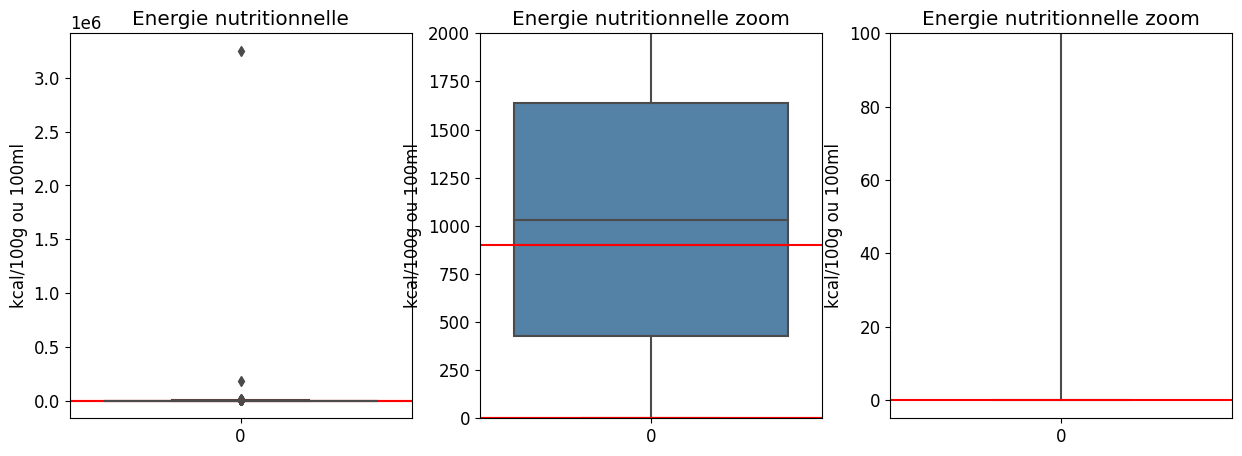

In [1416]:
# energy_100g (energie nutritionnelle en kcal pour 100g)
# Les glucides ou les protéines fournissent 4 kcal par gramme, 
# les lipides 9 kcal par gramme. Le maximum de calories pour 100 grammes serait 900 kcal pour un produit 100% composé de lipides.

box_plot(data_retained, 'energy_100g', 'Energie nutritionnelle', 0, 2000, -5, 100, 'kcal', 0, 900)

#### Beaucoup de valeurs depassant le seuil max de kcal pour 100g de produit

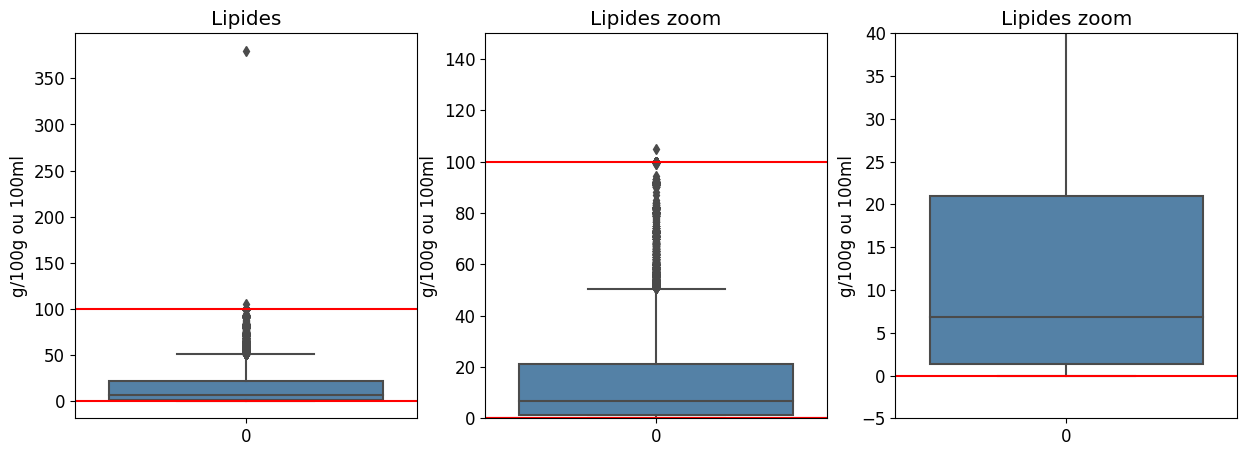

In [1417]:
# fat_100g (les lipides)
box_plot(data_retained, 'fat_100g', 'Lipides', 0, 150, -5, 40, 'g', 0, 100)

#### Des outliers qui depassent 100g pour 100g de produit au total

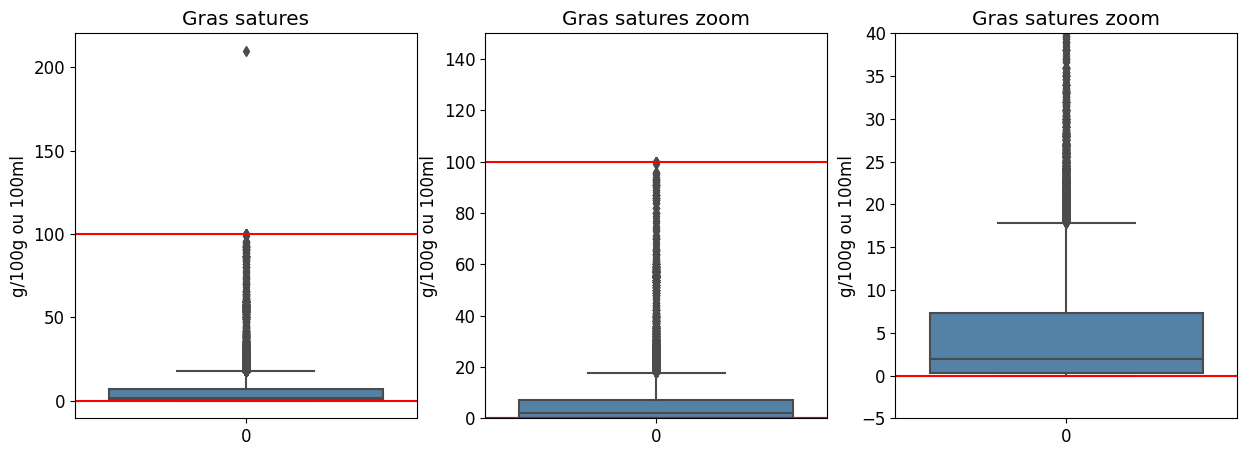

In [1418]:
# saturated_fat_100g (lipides)
box_plot(data_retained, 'saturated_fat_100g', 'Gras satures', 0, 150, -5, 40, 'g', 0, 100)

#### On retrouve des outliers qui depassent les 100g

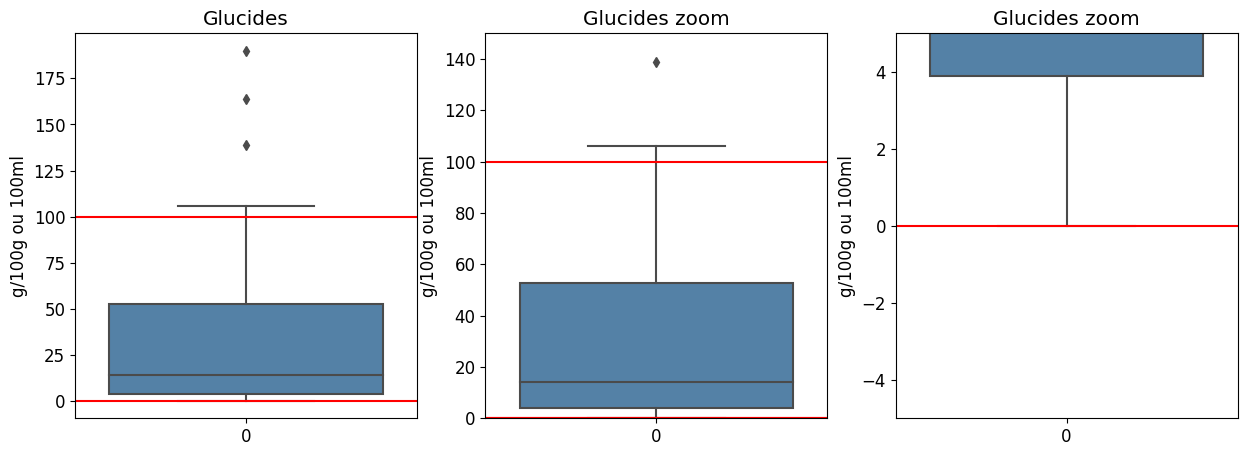

In [1419]:
# carbohydrates_100g (hydrates de carbone / glucide)
box_plot(data_retained, 'carbohydrates_100g', 'Glucides', 0, 150, -5, 5, 'g', 0, 100)

#### Des outliers depassant les 100g

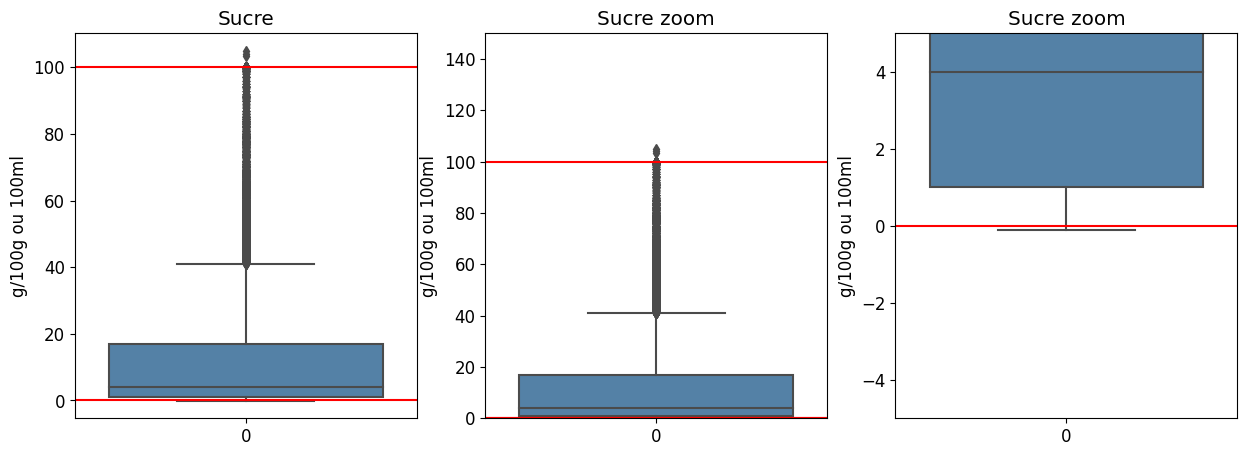

In [1420]:
# sugars_100g (Sucre)
box_plot(data_retained, 'sugars_100g', 'Sucre', 0, 150, -5, 5, 'g', 0, 100)

#### des outliers depassant les 100g + des valeurs negatives

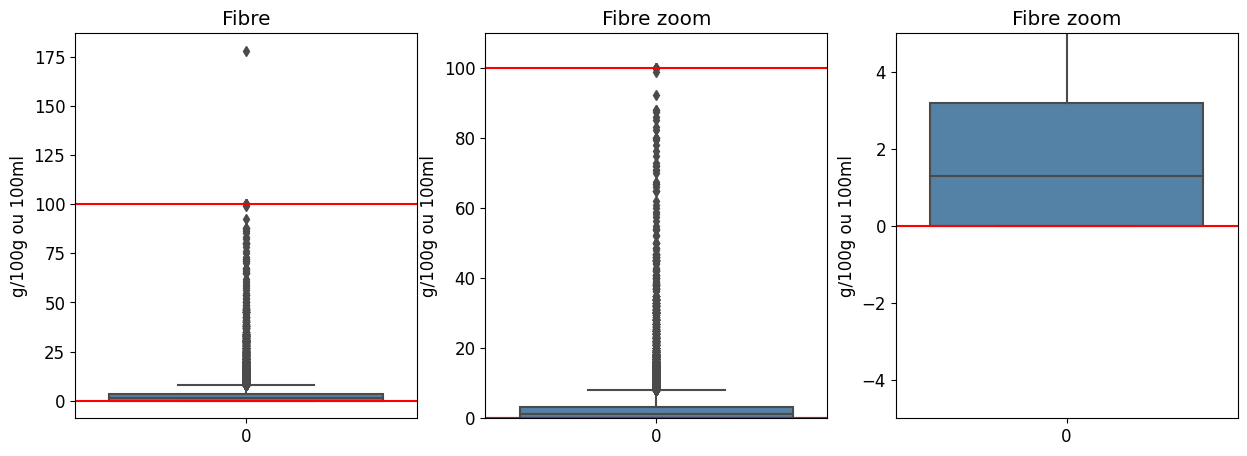

In [1421]:
# fiber_100g (Fibres)
box_plot(data_retained, 'fiber_100g', 'Fibre', 0, 110, -5, 5, 'g', 0, 100)

#### outliers depassant les 100g

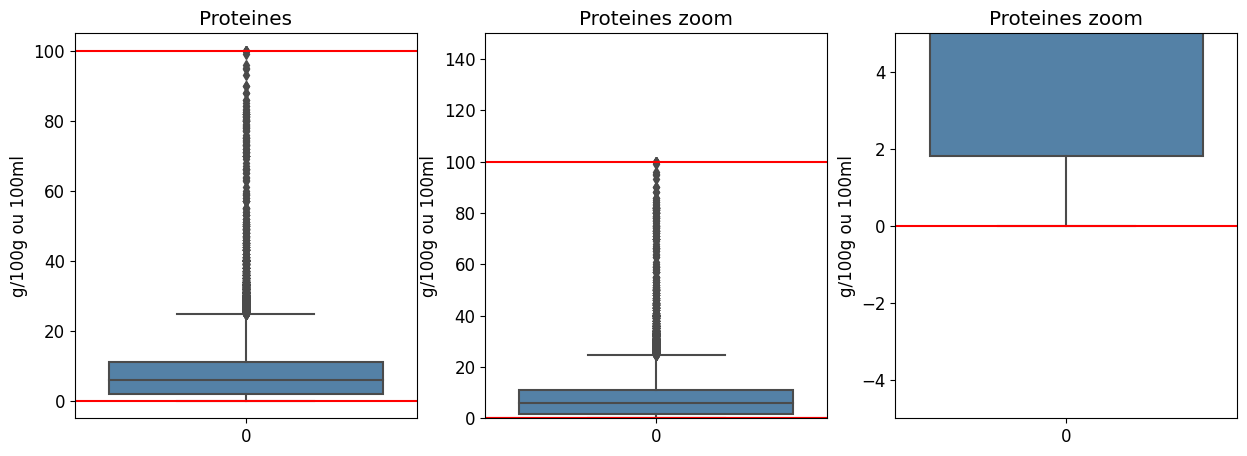

In [1422]:
# proteins_100g (Proteines)
box_plot(data_retained, 'proteins_100g', 'Proteines', 0, 150, -5, 5, 'g', 0, 100)

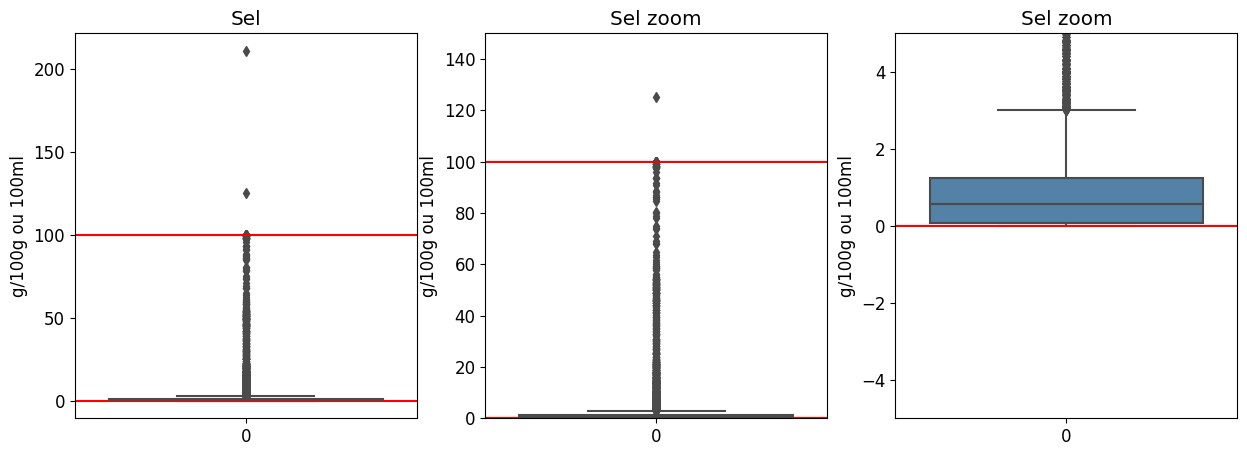

In [1423]:
# salt_100g (Sel)
box_plot(data_retained, 'salt_100g', 'Sel', 0, 150, -5, 5, 'g', 0, 100)

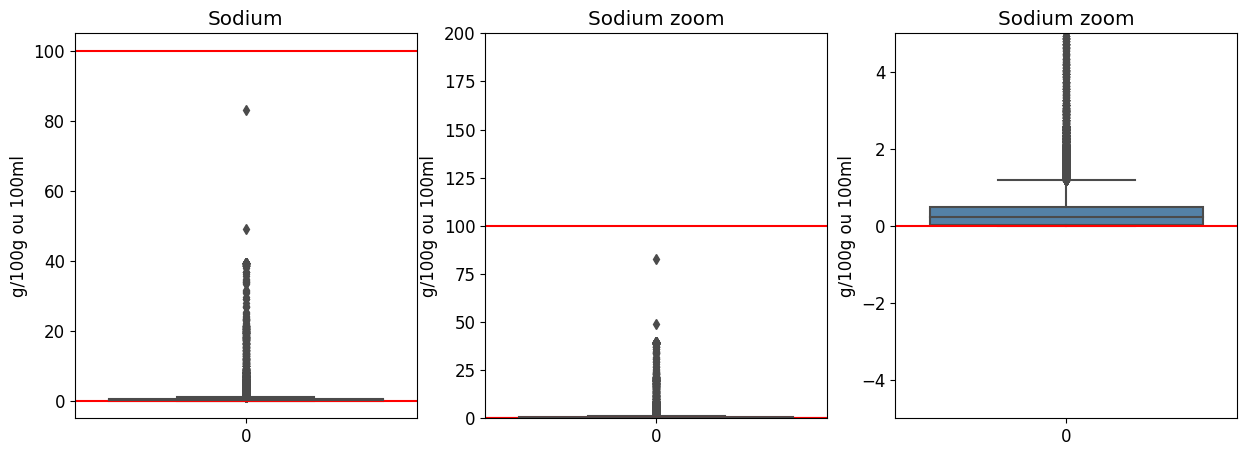

In [1424]:
# sodium_100g
box_plot(data_retained, 'sodium_100g', 'Sodium', 0, 200, -5, 5, 'g', 0, 100)

In [1425]:
data_retained.loc[data_retained['sodium_100g'] > data_retained['salt_100g'] / 2.5]['sodium_100g'].count().sum()

0

#### Il n'y a pas de produit pour laquelle la masse de sodium est suppa la masse de sel en g

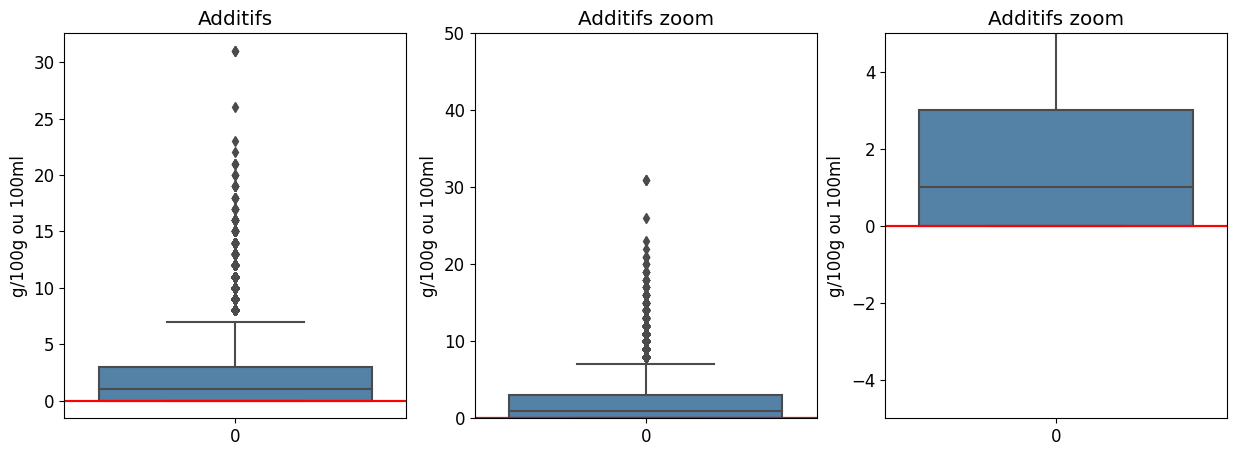

In [1426]:
# additives_n (Additifs)
box_plot(data_retained, 'additives_n', 'Additifs', 0, 50, -5, 5, 'g', 0, 0)

### Pas d'outliers dans les additifs

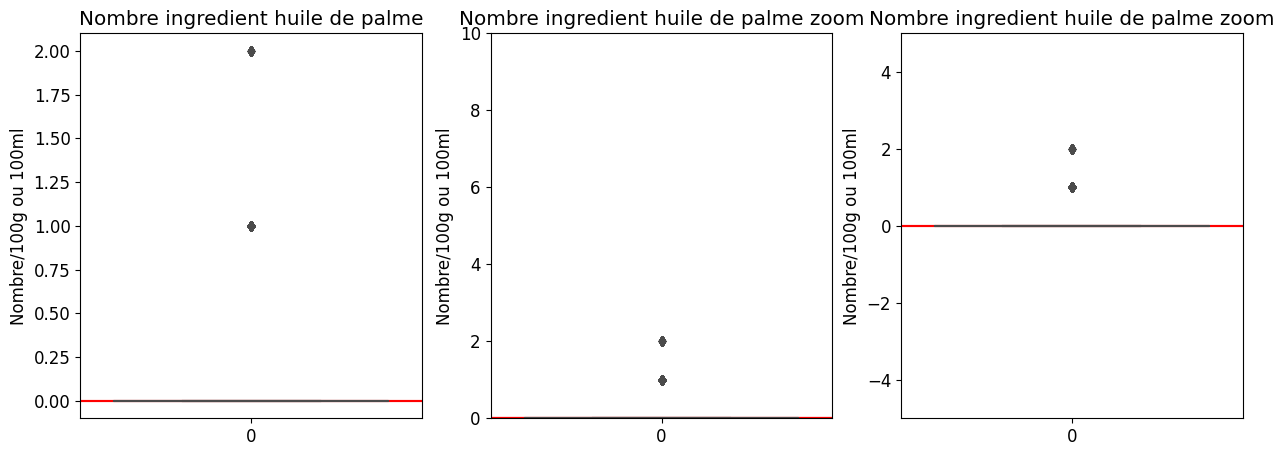

In [1427]:
# ingredients_from_palm_oil_n (nombre d'ingredients dhuile de palme)
box_plot(data_retained, 'ingredients_from_palm_oil_n', 'Nombre ingredient huile de palme', 0, 10, -5, 5, 'Nombre', 0, 0)

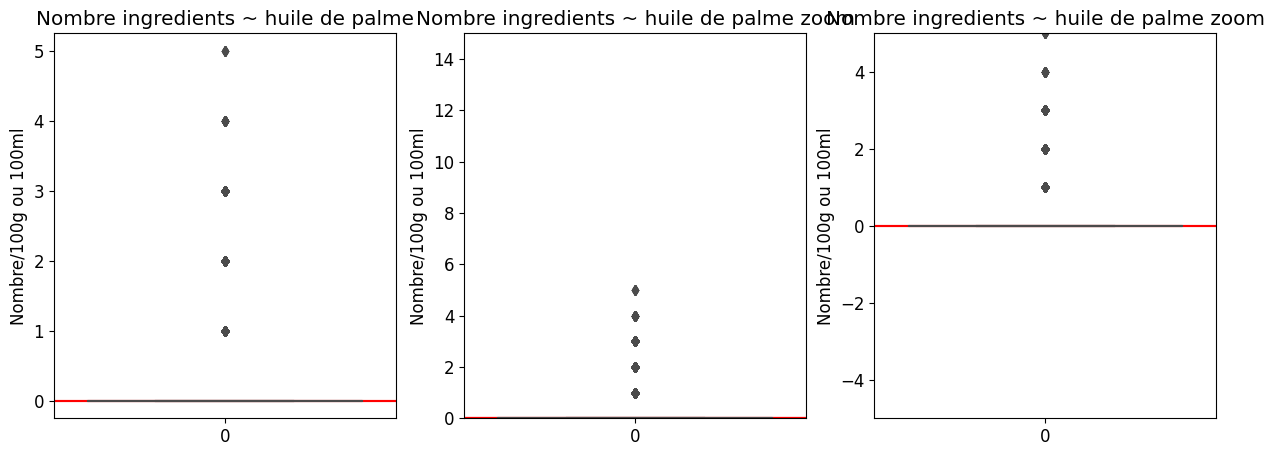

In [1428]:
# ingredients_that_may_be_from_palm_oil_n (Nombre d'ingredient qui peuvent  etre de l'huile de palme)
box_plot(data_retained, 'ingredients_that_may_be_from_palm_oil_n', 'Nombre ingredients ~ huile de palme', 0, 15, -5, 5, 'Nombre', 0, 0)

#### Pas de valeur aberrantes pour les deux categories

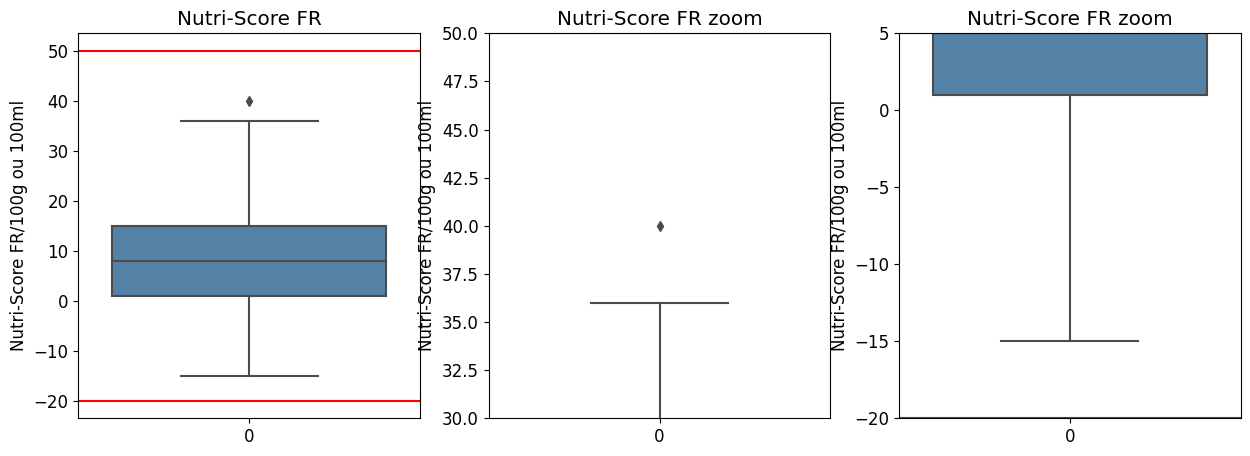

In [1429]:
# nutrition_score_fr_100g (nutri score FR)
box_plot(data_retained, 'nutrition_score_fr_100g', 'Nutri-Score FR', 30, 50, -20, 5, 'Nutri-Score FR', -20, 50)

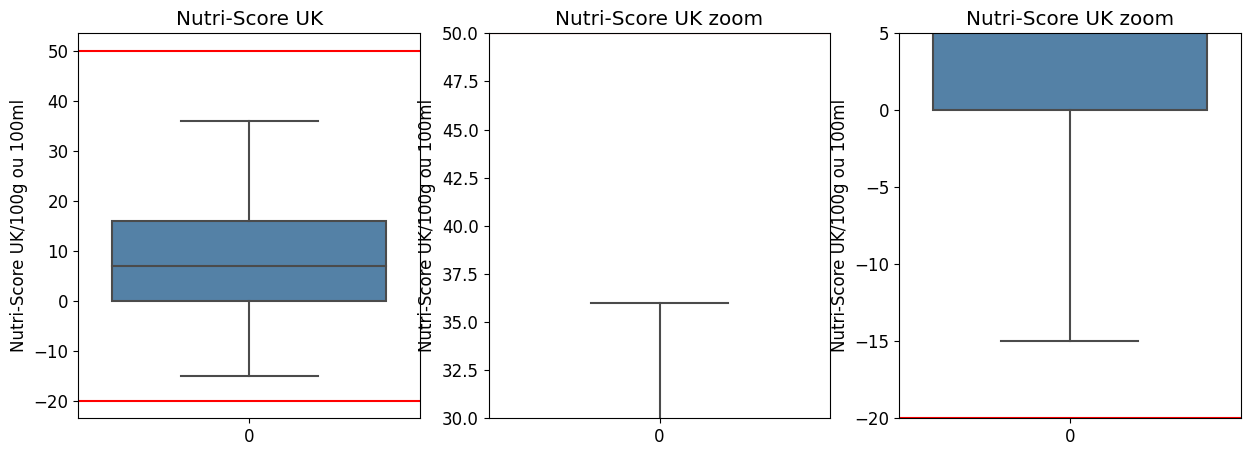

In [1430]:
# nutrition_score_uk_100g (nutri score UK)
box_plot(data_retained, 'nutrition_score_uk_100g', 'Nutri-Score UK', 30, 50, -20, 5, 'Nutri-Score UK', -20, 50)

#### Pas d'outliers pour les nutriscore FR et UK valeurs brut biern dans l'interval -15 40

### Passage sur les variables qualitatives

In [1431]:
data_retained['nutrition_grade_fr'].unique()

[NaN, 'd', 'e', 'c', 'b', 'a']
Categories (5, object): ['a', 'b', 'c', 'd', 'e']

In [1432]:
data_retained['nutrition_grade_fr'] = data_retained['nutrition_grade_fr'].str.upper().apply(str)

In [1433]:
data_retained['nutrition_grade_fr'].unique()

array(['nan', 'D', 'E', 'C', 'B', 'A'], dtype=object)

In [1434]:
# Préparation des variables de travail pour les graphiques et les tests
gb = data_retained.groupby('nutrition_grade_fr')['nutrition_score_fr_100g']
df_nutriscore = pd.DataFrame([gb.get_group(n).values for n in list('ABCDE')], index=list('ABCDE')).T

In [1435]:
df_nutriscore

,A,B,C,D,E
0,-2.0,1.0,6.0,14.0,13.0
1,-1.0,2.0,4.0,14.0,13.0
2,-2.0,2.0,5.0,15.0,22.0
3,-5.0,1.0,6.0,12.0,22.0
4,-4.0,1.0,5.0,13.0,19.0
...,...,...,...,...,...
16094,NaN,NaN,NaN,16.0,NaN
16095,NaN,NaN,NaN,11.0,NaN
16096,NaN,NaN,NaN,15.0,NaN
16097,NaN,NaN,NaN,17.0,NaN


In [1436]:
def stat_descriptives(dataframe, liste_variables):
    """
    Statistiques descriptives moyenne, mediane, variance, écart-type,
    skewness et kurtosis du dataframe transmis en paramètre
    ----------
    @param IN : dataframe : DataFrame, obligatoire
                liste_variables : colonne dont on veut voir les stat descr
    @param OUT : dataframe des statistiques descriptives
    """
    liste_mean = ['mean']
    liste_median = ['median']
    liste_var = ['var']
    liste_std = ['std']
    liste_skew = ['skew']
    liste_kurtosis = ['kurtosis']
    liste_mode = ['mode']
    liste_cols = ['Desc']
    liste_max = ['Max']
    liste_min = ['Min']

    for col in liste_variables:
        liste_mean.append(dataframe[col].mean())
        liste_median.append(dataframe[col].median())
        liste_var.append(dataframe[col].var(ddof=0))
        liste_std.append(dataframe[col].std(ddof=0))
        liste_skew.append(dataframe[col].skew())
        liste_kurtosis.append(dataframe[col].kurtosis())
        liste_cols.append(col)
        liste_mode.append(dataframe[col].mode().to_string())
        liste_min.append(dataframe[col].min())
        liste_max.append(dataframe[col].max())

    data_stats = [liste_mean, liste_median, liste_var, liste_std, liste_skew, liste_kurtosis, liste_mode, liste_min, liste_max]
    df_stat = pd.DataFrame(data_stats, columns=liste_cols)

    return df_stat.style.hide()

In [1437]:
stat_descriptives(df_nutriscore, ['A', 'B', 'C', 'D', 'E'])

Desc,A,B,C,D,E
mean,-3.646378,0.893699,5.656168,13.813218,21.343579
median,-3.000000,1.000000,5.000000,14.000000,21.000000
var,5.380946,0.905073,6.060973,6.417625,15.917239
std,2.319687,0.951353,2.461904,2.533303,3.989641
skew,-0.800461,-1.259006,0.468632,-0.328619,-0.488754
kurtosis,0.823912,6.184278,-1.129217,0.161318,0.836629
mode,0 -1.0,0 0.0,0 3.0,0 14.0,0 19.0
Min,-15.000000,-8.000000,2.000000,6.000000,10.000000
Max,10.000000,2.000000,10.000000,18.000000,40.000000


In [1438]:
cond1 = data_retained['nutrition_grade_fr'] == 'A'
cond2 = data_retained['nutrition_score_fr_100g'] > 0
data_retained[cond1 & cond2][['product_name', 'nutrition_grade_fr',
                         'nutrition_score_fr_100g']]

,product_name,nutrition_grade_fr,nutrition_score_fr_100g
180946,Pétillante saveur Citron,A,1.0
192052,Sans sucres Agrumes,A,1.0
192056,Evian,A,10.0
192065,La Salvetat Citron vert,A,1.0
192067,Badoit Citron,A,1.0
192073,Badoit Framboise,A,1.0
192119,La Salvetat Citron,A,1.0
198272,"Perrier citron vert, limoen",A,1.0
220374,Sémillante arômes naturels Citron,A,4.0
245670,Source St Jean,A,2.0


### Bilan : Valeur aberrantes a corriger

In [1439]:
# correction énergie pour 100g <= 900 kcal
data_retained['energy_100g'] = [np.nan if val > 900 else val for val in data_retained['energy_100g']]

In [1440]:
# corrections valeurs des variables en '_100g' >=0 et <=100
cols_100g = data_retained.columns[data_retained.columns.str.endswith('_100g')].to_list()
cols_100g.remove('energy_100g')
for col in cols_100g:
    data_retained[col] = [np.nan if val > 100 else np.nan if val < 0 else val for val in data_retained[col]]

In [1441]:
# correction masse totale des glucides est inférieure à la masse de sucre
data_retained = data_retained.drop(data_retained[data_retained['carbohydrates_100g'] < data_retained['sugars_100g']].index)

In [1442]:
# correction masse totale des lipides est inférieure à la masse des acides gras
data_retained['saturated_fat_100g'] = [np.nan if row[0] < row[1] else row[1] for row in zip(data_retained['fat_100g'], data_retained['saturated_fat_100g'])]

In [1443]:
# supprimer les produits si 2,5 * sodium > sel (en g).
# Produit avec taux de sodium*2.5 > taux de sel ?

data_retained = data_retained.drop(data_retained[data_retained['sodium_100g'] > data_retained['salt_100g']/2.4].index)

In [1444]:
data_retained_shape = data_retained.shape
print(f"Le jeu de donnee contient {data_retained_shape[0]} lignes et {data_retained_shape[1]} colonnes.")

Le jeu de donnee contient 87309 lignes et 29 colonnes.


### Mixer les colonnes contenant l'huile de palm

In [1445]:
# Regroupement des 2 variables avec nombre d'ingrédients d'huile de palme
data_retained['nb_ingredients_huile_palm'] = data_retained['ingredients_from_palm_oil_n'] + data_retained['ingredients_that_may_be_from_palm_oil_n']
# suppression des deux colonnes precedentes
data_retained.drop('ingredients_from_palm_oil_n', axis=1, inplace=True)
data_retained.drop('ingredients_that_may_be_from_palm_oil_n', axis=1, inplace=True)

In [1446]:
data_retained_shape = data_retained.shape
print(f"Le jeu de donnee contient {data_retained_shape[0]} lignes et {data_retained_shape[1]} colonnes.")

Le jeu de donnee contient 87309 lignes et 28 colonnes.


In [1447]:
# Regroupement de la variable sodium et salt
data_retained['sel'] = [row[0] if not np.isnan(row[0]) else row[1]*2.5 if not np.isnan(row[1]) else np.nan for row in zip(data_retained['salt_100g'], data_retained['sodium_100g'])]
# correction des valeurs aberrantes supp a 100g pour cette nouvelle colonne
data_retained['sel'] = [np.nan if val > 100 else val for val in data_retained['sel']]
# suppression des deux colonnes inutile
data_retained.drop('salt_100g', axis=1, inplace=True)
data_retained.drop('sodium_100g', axis=1, inplace=True)

In [1448]:
data_retained_shape = data_retained.shape
print(f"Le jeu de donnee contient {data_retained_shape[0]} lignes et {data_retained_shape[1]} colonnes.")

Le jeu de donnee contient 87309 lignes et 27 colonnes.


In [1449]:
data_retained.columns.to_list()

['code',
 'image_url',
 'product_name',
 'countries_fr',
 'pnns_groups_1',
 'pnns_groups_2',
 'brands',
 'energy_100g',
 'fat_100g',
 'saturated_fat_100g',
 'trans_fat_100g',
 'cholesterol_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'vitamin_a_100g',
 'vitamin_c_100g',
 'calcium_100g',
 'iron_100g',
 'nutrition_score_fr_100g',
 'nutrition_score_uk_100g',
 'additives_n',
 'additives_fr',
 'nutrition_grade_fr',
 'nb_ingredients_huile_palm',
 'sel']

### Verification des valeurs manquantes apres corrections

In [1450]:
def get_missing_values(df_work, pourcentage, affiche_heatmap):
    """Indicateurs sur les variables manquantes
       @param in : df_work dataframe obligatoire
                   pourcentage : boolean si True affiche le nombre heatmap
                   affiche_heatmap : boolean si True affiche la heatmap
       @param out : none
    """

    # 1. Nombre de valeurs manquantes totales
    nb_nan_tot = df_work.isna().sum().sum()
    nb_donnees_tot = np.prod(df_work.shape)
    pourc_nan_tot = round((nb_nan_tot / nb_donnees_tot) * 100, 2)
    print(
        f'Valeurs manquantes :{nb_nan_tot} NaN pour {nb_donnees_tot} données ({pourc_nan_tot} %)')

    if pourcentage:
        print("-------------------------------------------------------------")
        print("Nombre et pourcentage de valeurs manquantes par variable\n")
        # 2. Visualisation du nombre et du pourcentage de valeurs manquantes
        # par variable
        values = df_work.isnull().sum()
        percentage = 100 * values / len(df_work)
        table = pd.concat([values, percentage.round(2)], axis=1)
        table.columns = [
            'Nombres de valeurs manquantes',
            '% de valeurs manquantes']
        display(table[table['Nombres de valeurs manquantes'] != 0]
                .sort_values('% de valeurs manquantes', ascending=False)
                .style.background_gradient('seismic'))

    if affiche_heatmap:
        print("-------------------------------------------------------------")
        print("Heatmap de visualisation des valeurs manquantes")
        # 3. Heatmap de visualisation des valeurs manquantes
        plt.figure(figsize=(20, 10))
        sns.heatmap(df_work.isna(), cbar=False)
        plt.show()

In [1451]:
get_missing_values(data_retained, True, False)

Valeurs manquantes :1078453 NaN pour 2357343 données (45.75 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



,Nombres de valeurs manquantes,% de valeurs manquantes
trans_fat_100g,87100,99.760000
cholesterol_100g,87062,99.720000
vitamin_a_100g,86891,99.520000
iron_100g,86399,98.960000
vitamin_c_100g,86231,98.770000
calcium_100g,85416,97.830000
energy_100g,59561,68.220000
additives_fr,58724,67.260000
fiber_100g,43922,50.310000
carbohydrates_100g,43523,49.850000


In [1452]:
data_retained.columns.tolist()

['code',
 'image_url',
 'product_name',
 'countries_fr',
 'pnns_groups_1',
 'pnns_groups_2',
 'brands',
 'energy_100g',
 'fat_100g',
 'saturated_fat_100g',
 'trans_fat_100g',
 'cholesterol_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'vitamin_a_100g',
 'vitamin_c_100g',
 'calcium_100g',
 'iron_100g',
 'nutrition_score_fr_100g',
 'nutrition_score_uk_100g',
 'additives_n',
 'additives_fr',
 'nutrition_grade_fr',
 'nb_ingredients_huile_palm',
 'sel']

In [1453]:
data_work_nan = round((data_retained.isna().sum() / data_retained.shape[0]) * 100, 2)
cols = data_retained.columns.tolist()

# Conservation seulement des variables avec valeurs manquantes >= 80%
seuil = 70
cols_a_garder = data_work_nan[data_work_nan.values < seuil].index.tolist()

cols_info_gen_supprimees = [col for col in cols if col not in cols_a_garder]

data_retained = data_retained[cols_a_garder]

print(f'Liste des variables éliminées :\n{cols_info_gen_supprimees}\n')
print(f'Liste des variables conservées :\n{cols_a_garder}')

Liste des variables éliminées :
['trans_fat_100g', 'cholesterol_100g', 'vitamin_a_100g', 'vitamin_c_100g', 'calcium_100g', 'iron_100g']

Liste des variables conservées :
['code', 'image_url', 'product_name', 'countries_fr', 'pnns_groups_1', 'pnns_groups_2', 'brands', 'energy_100g', 'fat_100g', 'saturated_fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'nutrition_score_fr_100g', 'nutrition_score_uk_100g', 'additives_n', 'additives_fr', 'nutrition_grade_fr', 'nb_ingredients_huile_palm', 'sel']


In [1454]:
data_retained.drop(['additives_fr', 'additives_n', 'image_url'], axis=1, inplace=True)

In [1455]:
get_missing_values(data_retained, True, False)

Valeurs manquantes :423375 NaN pour 1571562 données (26.94 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



,Nombres de valeurs manquantes,% de valeurs manquantes
energy_100g,59561,68.220000
fiber_100g,43922,50.310000
carbohydrates_100g,43523,49.850000
fat_100g,43102,49.370000
nutrition_score_uk_100g,40309,46.170000
nutrition_score_fr_100g,38992,44.660000
nb_ingredients_huile_palm,36948,42.320000
saturated_fat_100g,28377,32.500000
sugars_100g,28223,32.330000
sel,28162,32.260000


In [1456]:
cols = data_retained.select_dtypes(include=[np.number]).columns.to_list()

In [1457]:
corr = data_retained[cols].corr()

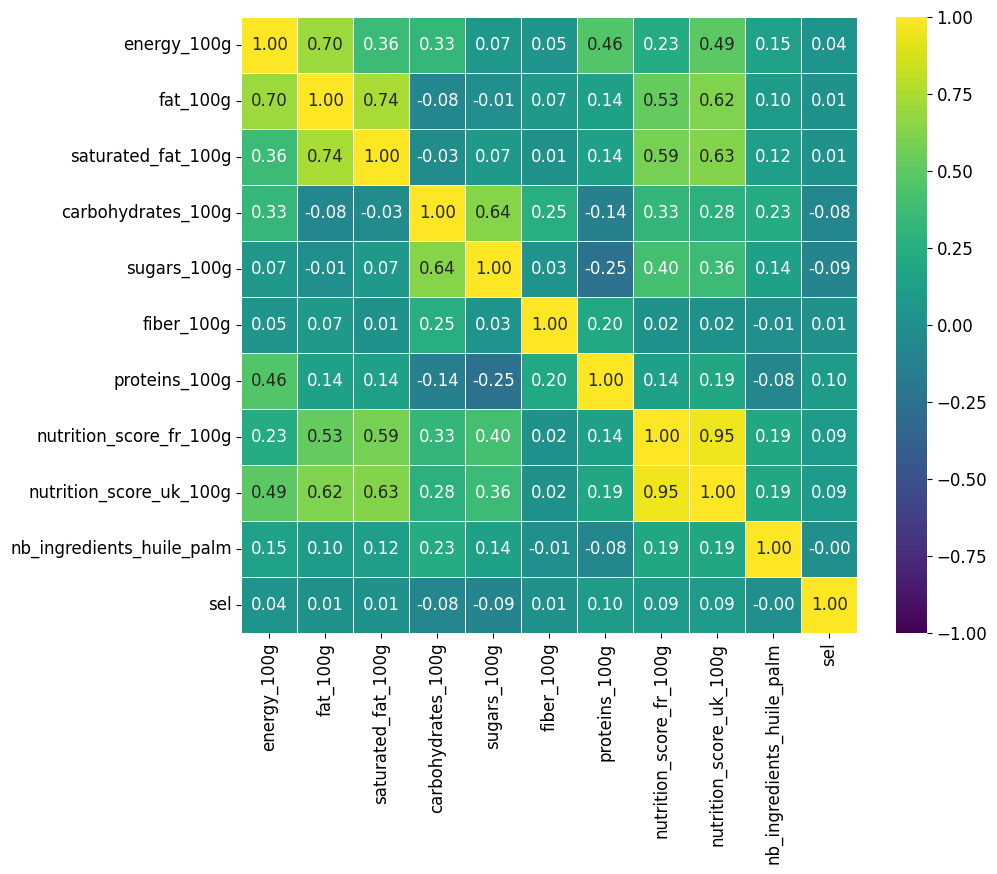

In [1458]:
plt.figure(figsize = (10,8))
plt.rcParams.update({'font.size': 12})
sns.heatmap(corr, cmap = 'viridis', vmin = -1, vmax = 1, center = 0, annot=True, fmt=".2f", square=True, linewidths=.5)
plt.show()

In [1459]:
# verifier si certains groupes de produit sont plus impactes par les valeurs manquantes
nan_par_groupe = data_retained.groupby("pnns_groups_1").apply(lambda x: x.isnull().mean() * 100)

# Calculer les statistiques globales sur les valeurs manquantes par groupe
nan_par_groupe_sum = nan_par_groupe.describe()

nan_par_groupe_sum

,code,product_name,countries_fr,pnns_groups_1,pnns_groups_2,brands,energy_100g,fat_100g,saturated_fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,nutrition_score_fr_100g,nutrition_score_uk_100g,nutrition_grade_fr,nb_ingredients_huile_palm,sel
count,10.0,10.0,10.0,10.0,10.0,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.0,10.000000,10.000000
mean,0.0,0.0,0.0,0.0,0.0,2.093169,63.539797,28.999855,24.430767,29.737984,24.256041,49.084469,21.605706,39.415039,41.569204,0.0,21.212595,24.156331
std,0.0,0.0,0.0,0.0,0.0,4.230622,24.426739,20.891636,10.187724,20.407690,10.007643,12.811360,10.482294,19.706108,20.412741,0.0,20.375424,9.989358
min,0.0,0.0,0.0,0.0,0.0,0.251004,34.284250,13.375470,13.052209,13.546293,13.152610,26.753384,11.001025,16.064257,16.014056,0.0,10.129826,13.204646
25%,0.0,0.0,0.0,0.0,0.0,0.623807,40.651950,15.429050,16.240491,16.891436,16.382503,40.120587,12.605879,26.121368,26.114373,0.0,13.164304,16.501613
50%,0.0,0.0,0.0,0.0,0.0,0.865244,61.040904,24.006787,22.430517,24.716426,22.229959,50.000120,19.846404,35.665464,36.975034,0.0,14.670230,22.527616
75%,0.0,0.0,0.0,0.0,0.0,0.920064,83.902151,30.598968,30.909386,30.411849,30.012691,57.364099,26.770455,49.884415,56.296273,0.0,16.817276,29.981411
max,0.0,0.0,0.0,0.0,0.0,14.108388,97.038153,83.200401,45.394042,83.266427,45.288401,70.396729,44.570040,80.778698,80.778698,0.0,78.084724,45.251426


## Imputation avec KNNImputer + Analyse Uni/Bivariee

### Les colonnes fortement corrélées peuvent servir pour une imputation par régression ou KNN.
#### Compléter saturated_fat_100g à partir de fat_100g.
#### Compléter sugars_100g à partir de carbohydrates_100g.

In [1460]:
nan_values = data_retained.isnull().mean() * 100

# Trier les colonnes par pourcentage de valeurs manquantes
missing_values_sorted = nan_values.sort_values(ascending=False)

missing_values_sorted

energy_100g                  68.218626
fiber_100g                   50.306383
carbohydrates_100g           49.849386
fat_100g                     49.367190
nutrition_score_uk_100g      46.168207
nutrition_score_fr_100g      44.659772
nb_ingredients_huile_palm    42.318661
saturated_fat_100g           32.501804
sugars_100g                  32.325419
sel                          32.255552
proteins_100g                30.385184
brands                        6.559461
product_name                  0.000000
pnns_groups_2                 0.000000
pnns_groups_1                 0.000000
nutrition_grade_fr            0.000000
countries_fr                  0.000000
code                          0.000000
dtype: float64

In [1461]:
# creation d'une variable copie
data_retained_bis = data_retained.copy()

# Sélection des colonnes fortement corrélées pour une imputation automatique
columns_to_impute = ['saturated_fat_100g', 'fat_100g', 'energy_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'sel', 'nutrition_score_uk_100g', 'nutrition_score_fr_100g']

# Préparer les données pour KNN Imputation
data_for_imputation = data_retained_bis[columns_to_impute]

# Initialiser le KNN Imputer
knn_imputer = KNNImputer(n_neighbors=5)

# Appliquer l'imputation
data_retained_imputed = pd.DataFrame(knn_imputer.fit_transform(data_for_imputation), columns=columns_to_impute, index=data_for_imputation.index)

# Ajouter les données imputées au dataset original
data_retained_bis[columns_to_impute] = data_retained_imputed

# Vérifier les valeurs manquantes après imputation
missing_after_imputation = data_retained_bis[columns_to_impute].isnull().sum()

missing_after_imputation


saturated_fat_100g         0
fat_100g                   0
energy_100g                0
carbohydrates_100g         0
sugars_100g                0
fiber_100g                 0
proteins_100g              0
sel                        0
nutrition_score_uk_100g    0
nutrition_score_fr_100g    0
dtype: int64

In [1462]:
nan_values = data_retained_bis.isnull().mean() * 100

# Trier les colonnes par pourcentage de valeurs manquantes
missing_values_sorted = nan_values.sort_values(ascending=False)

missing_values_sorted

nb_ingredients_huile_palm    42.318661
brands                        6.559461
code                          0.000000
sugars_100g                   0.000000
nutrition_grade_fr            0.000000
nutrition_score_uk_100g       0.000000
nutrition_score_fr_100g       0.000000
proteins_100g                 0.000000
fiber_100g                    0.000000
carbohydrates_100g            0.000000
product_name                  0.000000
saturated_fat_100g            0.000000
fat_100g                      0.000000
energy_100g                   0.000000
pnns_groups_2                 0.000000
pnns_groups_1                 0.000000
countries_fr                  0.000000
sel                           0.000000
dtype: float64

In [1463]:
data_retained_bis

,code,product_name,countries_fr,pnns_groups_1,pnns_groups_2,brands,energy_100g,fat_100g,saturated_fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,nutrition_score_fr_100g,nutrition_score_uk_100g,nutrition_grade_fr,nb_ingredients_huile_palm,sel
0,0000000003087,Farine de blé noir,France,a renseigner,a renseigner,Ferme t'y R'nao,407.091301,13.269494,5.381967,27.30315,13.221379,2.520862,7.79986,11.08436,11.10383,nan,NaN,1.156668
46,0000000024600,Filet de bœuf,France,a renseigner,a renseigner,NaN,407.091301,13.269494,5.381967,27.30315,13.221379,2.520862,7.79986,11.08436,11.10383,nan,NaN,1.156668
136,0000000039259,Twix x2,France,a renseigner,a renseigner,NaN,407.091301,13.269494,5.381967,27.30315,13.221379,2.520862,7.79986,11.08436,11.10383,nan,NaN,1.156668
182,0000005200016,lentilles vertes,France,cereales et pommes de terre,legumineuses,Bertrand Lejeune,407.091301,13.269494,5.381967,27.30315,13.221379,2.520862,7.79986,11.08436,11.10383,nan,0.0,1.156668
184,0000007730009,Biscuits sablés fourrage au cacao,France,collation sucree,biscuits et gateaux,St Michel,407.091301,13.269494,5.381967,27.30315,13.221379,2.520862,7.79986,11.08436,11.10383,nan,1.0,1.156668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320761,9906410000009,Roussette du Bugey (2011),France,a renseigner,boissons alcoolisees,Roussette du Bugey,407.091301,13.269494,5.381967,27.30315,13.221379,2.520862,7.79986,11.08436,11.10383,nan,NaN,1.156668
320763,99111250,Thé vert Earl grey,France,boissons,non sugared beverages,Lobodis,21.000000,0.200000,0.200000,0.50000,0.500000,0.200000,0.50000,2.00000,0.00000,C,0.0,0.025400
320764,9918,"Cheese cake thé vert, yuzu",France,a renseigner,a renseigner,NaN,407.091301,13.269494,5.381967,27.30315,13.221379,2.520862,7.79986,11.08436,11.10383,nan,NaN,1.156668
320765,9935010000003,Rillette d'oie,France,poisson viande oeufs,viande transformee,"Sans marque,D.Lambert",407.091301,13.269494,5.381967,27.30315,13.221379,2.520862,7.79986,11.08436,11.10383,nan,0.0,1.156668


In [1464]:
data = pd.read_csv('data_retained.csv', low_memory=False)

# Calculer les corrélations entre les colonnes numériques
numeric_columns = data.select_dtypes(include=['float64']).columns
correlation_matrix = data[numeric_columns].corr()

# Sélectionner les colonnes ayant une forte corrélation avec les colonnes à imputer
columns_to_include = set(columns_to_impute)
threshold = 0.5  # Seulement les corrélations > 0.5
for col in columns_to_impute:
    highly_corr_cols = correlation_matrix[col][correlation_matrix[col] > threshold].index.tolist()
    columns_to_include.update(highly_corr_cols)

# Convertir le set en liste pour utilisation
columns_to_include = list(columns_to_include)

# Vérifier les colonnes sélectionnées pour enrichir le KNN
columns_to_include


['proteins_100g',
 'saturated_fat_100g',
 'sel',
 'carbohydrates_100g',
 'energy_100g',
 'nutrition_score_fr_100g',
 'sugars_100g',
 'nutrition_score_uk_100g',
 'fiber_100g',
 'fat_100g']

In [1465]:
# Identifier les lignes où toutes les colonnes sélectionnées sont complètes
complete_rows = data[columns_to_include].dropna()

# Identifier les lignes où il manque des données
incomplete_rows = data[columns_to_include][~data.index.isin(complete_rows.index)]

# Vérifier les tailles des ensembles
complete_rows_size = complete_rows.shape
incomplete_rows_size = incomplete_rows.shape

print(complete_rows_size)
print(incomplete_rows_size)

(7141, 10)
(80168, 10)


In [1466]:
complete_rows

,proteins_100g,saturated_fat_100g,sel,carbohydrates_100g,energy_100g,nutrition_score_fr_100g,sugars_100g,nutrition_score_uk_100g,fiber_100g,fat_100g
12,0.0,0.0,0.02540,10.4,177.0,13.0,10.4,2.0,0.000,0.0
43,0.3,0.8,0.63000,3.6,126.0,1.0,2.7,1.0,1.000,1.4
51,0.8,0.7,0.75000,5.3,188.0,2.0,2.4,2.0,0.800,2.1
137,0.0,0.0,0.02310,15.8,266.0,18.0,13.3,2.0,0.303,0.0
143,0.0,0.0,0.08636,14.0,234.0,3.0,14.0,3.0,0.000,0.0
...,...,...,...,...,...,...,...,...,...,...
87240,1.3,11.0,0.03000,2.1,543.0,11.0,1.5,11.0,0.500,13.0
87242,4.5,0.1,16.25600,12.0,277.0,12.0,11.2,12.0,0.200,0.1
87245,1.8,0.6,6.81736,19.9,525.0,11.0,16.0,11.0,2.700,4.2
87255,2.0,0.2,0.00000,8.1,214.0,0.0,7.8,0.0,0.000,1.1


In [1467]:
incomplete_rows

,proteins_100g,saturated_fat_100g,sel,carbohydrates_100g,energy_100g,nutrition_score_fr_100g,sugars_100g,nutrition_score_uk_100g,fiber_100g,fat_100g
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
87303,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87306,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87307,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1468]:
# Appliquer le KNN Imputer uniquement sur les lignes complètes pour calculer les distances
knn_imputer = KNNImputer(n_neighbors=5)
imputed_complete_rows = pd.DataFrame(knn_imputer.fit_transform(complete_rows), columns=columns_to_include)

In [1469]:
imputed_complete_rows

,proteins_100g,saturated_fat_100g,sel,carbohydrates_100g,energy_100g,nutrition_score_fr_100g,sugars_100g,nutrition_score_uk_100g,fiber_100g,fat_100g
0,0.0,0.0,0.02540,10.4,177.0,13.0,10.4,2.0,0.000,0.0
1,0.3,0.8,0.63000,3.6,126.0,1.0,2.7,1.0,1.000,1.4
2,0.8,0.7,0.75000,5.3,188.0,2.0,2.4,2.0,0.800,2.1
3,0.0,0.0,0.02310,15.8,266.0,18.0,13.3,2.0,0.303,0.0
4,0.0,0.0,0.08636,14.0,234.0,3.0,14.0,3.0,0.000,0.0
...,...,...,...,...,...,...,...,...,...,...
7136,1.3,11.0,0.03000,2.1,543.0,11.0,1.5,11.0,0.500,13.0
7137,4.5,0.1,16.25600,12.0,277.0,12.0,11.2,12.0,0.200,0.1
7138,1.8,0.6,6.81736,19.9,525.0,11.0,16.0,11.0,2.700,4.2
7139,2.0,0.2,0.00000,8.1,214.0,0.0,7.8,0.0,0.000,1.1


In [1470]:
# Réutiliser ces distances pour imputer les lignes incomplètes
knn_imputer.fit(imputed_complete_rows)

KNNImputer()

In [1471]:
imputed_incomplete_rows = pd.DataFrame(knn_imputer.transform(incomplete_rows), columns=columns_to_include)

In [1472]:
imputed_incomplete_rows

,proteins_100g,saturated_fat_100g,sel,carbohydrates_100g,energy_100g,nutrition_score_fr_100g,sugars_100g,nutrition_score_uk_100g,fiber_100g,fat_100g
0,5.467131,1.776243,1.245131,11.255159,448.618069,4.602017,6.235894,3.542641,1.019186,4.620961
1,5.467131,1.776243,1.245131,11.255159,448.618069,4.602017,6.235894,3.542641,1.019186,4.620961
2,5.467131,1.776243,1.245131,11.255159,448.618069,4.602017,6.235894,3.542641,1.019186,4.620961
3,5.467131,1.776243,1.245131,11.255159,448.618069,4.602017,6.235894,3.542641,1.019186,4.620961
4,5.467131,1.776243,1.245131,11.255159,448.618069,4.602017,6.235894,3.542641,1.019186,4.620961
...,...,...,...,...,...,...,...,...,...,...
80163,5.467131,1.776243,1.245131,11.255159,448.618069,4.602017,6.235894,3.542641,1.019186,4.620961
80164,5.467131,1.776243,1.245131,11.255159,448.618069,4.602017,6.235894,3.542641,1.019186,4.620961
80165,5.467131,1.776243,1.245131,11.255159,448.618069,4.602017,6.235894,3.542641,1.019186,4.620961
80166,5.467131,1.776243,1.245131,11.255159,448.618069,4.602017,6.235894,3.542641,1.019186,4.620961


In [1473]:
# Réintégrer les lignes complètes et imputées dans le dataset principal
data_imputed = data.copy()
data_imputed.loc[complete_rows.index, columns_to_include] = imputed_complete_rows
data_imputed.loc[incomplete_rows.index, columns_to_include] = imputed_incomplete_rows

# Vérifier les valeurs manquantes après imputation
missing_after_filtered_knn = data_imputed[columns_to_impute].isnull().sum()

complete_rows_size, incomplete_rows_size, missing_after_filtered_knn

((7141, 10),
 (80168, 10),
 saturated_fat_100g         13494
 fat_100g                   13494
 energy_100g                13494
 carbohydrates_100g         13494
 sugars_100g                13494
 fiber_100g                 13494
 proteins_100g              13494
 sel                        13494
 nutrition_score_uk_100g    13494
 nutrition_score_fr_100g    13494
 dtype: int64)

## Autres essais

In [1474]:
cols = data_retained.select_dtypes(include=[np.number]).columns.to_list()

In [1475]:
# Copie du jeu de données
df_tmp =  data_retained.copy()
df_tmp = df_tmp[cols]

In [1476]:
# Mise à l'échelle des variables numériques
scaler = MinMaxScaler()

df_tmp_scaled = pd.DataFrame(scaler.fit_transform(df_tmp), columns=df_tmp.columns)

In [1477]:
# Imputation avec KNN et k best paramètre = 9
impute = KNNImputer(n_neighbors=9)

df_tmp_knn = pd.DataFrame(impute.fit_transform(df_tmp_scaled), columns=df_tmp_scaled.columns)

In [1478]:
df_tmp_knn

,energy_100g,fat_100g,saturated_fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,nutrition_score_fr_100g,nutrition_score_uk_100g,nb_ingredients_huile_palm,sel
0,0.452324,0.132695,0.053820,0.273031,0.132214,0.025209,0.077999,0.277109,0.308440,0.036109,0.011567
1,0.452324,0.132695,0.053820,0.273031,0.132214,0.025209,0.077999,0.277109,0.308440,0.036109,0.011567
2,0.452324,0.132695,0.053820,0.273031,0.132214,0.025209,0.077999,0.277109,0.308440,0.036109,0.011567
3,0.734815,0.212778,0.014000,0.149089,0.034333,0.024111,0.181000,0.166667,0.027778,0.000000,0.009944
4,0.701481,0.199889,0.077111,0.575556,0.096111,0.016889,0.053222,0.363889,0.395062,0.166667,0.006921
...,...,...,...,...,...,...,...,...,...,...,...
87304,0.452324,0.132695,0.053820,0.273031,0.132214,0.025209,0.077999,0.277109,0.308440,0.036109,0.011567
87305,0.023333,0.002000,0.002000,0.005000,0.005000,0.002000,0.005000,0.050000,0.000000,0.000000,0.000254
87306,0.452324,0.132695,0.053820,0.273031,0.132214,0.025209,0.077999,0.277109,0.308440,0.036109,0.011567
87307,0.734815,0.212778,0.014000,0.149089,0.034333,0.022000,0.181000,0.186111,0.027778,0.000000,0.009944


In [1479]:
# Supprimer la mise à l'échelle
df_tmp_knn_inverse = pd.DataFrame(scaler.inverse_transform(df_tmp_knn), columns=df_tmp_knn.columns)

In [1480]:
df_tmp_knn_inverse

,energy_100g,fat_100g,saturated_fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,nutrition_score_fr_100g,nutrition_score_uk_100g,nb_ingredients_huile_palm,sel
0,407.091301,13.269494,5.381967,27.303150,13.221379,2.520862,7.799860,11.084360,11.103830,0.216656,1.156668
1,407.091301,13.269494,5.381967,27.303150,13.221379,2.520862,7.799860,11.084360,11.103830,0.216656,1.156668
2,407.091301,13.269494,5.381967,27.303150,13.221379,2.520862,7.799860,11.084360,11.103830,0.216656,1.156668
3,661.333333,21.277778,1.400000,14.908889,3.433333,2.411111,18.100000,6.666667,1.000000,0.000000,0.994444
4,631.333333,19.988889,7.711111,57.555556,9.611111,1.688889,5.322222,14.555556,14.222222,1.000000,0.692140
...,...,...,...,...,...,...,...,...,...,...,...
87304,407.091301,13.269494,5.381967,27.303150,13.221379,2.520862,7.799860,11.084360,11.103830,0.216656,1.156668
87305,21.000000,0.200000,0.200000,0.500000,0.500000,0.200000,0.500000,2.000000,0.000000,0.000000,0.025400
87306,407.091301,13.269494,5.381967,27.303150,13.221379,2.520862,7.799860,11.084360,11.103830,0.216656,1.156668
87307,661.333333,21.277778,1.400000,14.908889,3.433333,2.200000,18.100000,7.444444,1.000000,0.000000,0.994444


In [1481]:
# Travail sur une copie du dataframe imputé
df_tmp_imput = df_tmp_knn_inverse.copy()
df_tmp_imput['index'] = range(0, len(df_tmp_imput))

In [1482]:
df_tmp_imput

,energy_100g,fat_100g,saturated_fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,nutrition_score_fr_100g,nutrition_score_uk_100g,nb_ingredients_huile_palm,sel,index
0,407.091301,13.269494,5.381967,27.303150,13.221379,2.520862,7.799860,11.084360,11.103830,0.216656,1.156668,0
1,407.091301,13.269494,5.381967,27.303150,13.221379,2.520862,7.799860,11.084360,11.103830,0.216656,1.156668,1
2,407.091301,13.269494,5.381967,27.303150,13.221379,2.520862,7.799860,11.084360,11.103830,0.216656,1.156668,2
3,661.333333,21.277778,1.400000,14.908889,3.433333,2.411111,18.100000,6.666667,1.000000,0.000000,0.994444,3
4,631.333333,19.988889,7.711111,57.555556,9.611111,1.688889,5.322222,14.555556,14.222222,1.000000,0.692140,4
...,...,...,...,...,...,...,...,...,...,...,...,...
87304,407.091301,13.269494,5.381967,27.303150,13.221379,2.520862,7.799860,11.084360,11.103830,0.216656,1.156668,87304
87305,21.000000,0.200000,0.200000,0.500000,0.500000,0.200000,0.500000,2.000000,0.000000,0.000000,0.025400,87305
87306,407.091301,13.269494,5.381967,27.303150,13.221379,2.520862,7.799860,11.084360,11.103830,0.216656,1.156668,87306
87307,661.333333,21.277778,1.400000,14.908889,3.433333,2.200000,18.100000,7.444444,1.000000,0.000000,0.994444,87307


In [1483]:
# Travail préparatoire au merge pour le dataframe nettoyé non imputé
df_tmp_appli = data_retained.copy()
# merge sur cette nouvelle variable index
df_tmp_appli['index'] = range(0, len(df_tmp_appli))
cols = data_retained.select_dtypes(include=[np.number]).columns.to_list()
df_tmp_appli.drop(cols, axis=1, inplace=True)

In [1484]:
df_tmp_appli

,code,product_name,countries_fr,pnns_groups_1,pnns_groups_2,brands,nutrition_grade_fr,index
0,0000000003087,Farine de blé noir,France,a renseigner,a renseigner,Ferme t'y R'nao,nan,0
46,0000000024600,Filet de bœuf,France,a renseigner,a renseigner,NaN,nan,1
136,0000000039259,Twix x2,France,a renseigner,a renseigner,NaN,nan,2
182,0000005200016,lentilles vertes,France,cereales et pommes de terre,legumineuses,Bertrand Lejeune,nan,3
184,0000007730009,Biscuits sablés fourrage au cacao,France,collation sucree,biscuits et gateaux,St Michel,nan,4
...,...,...,...,...,...,...,...,...
320761,9906410000009,Roussette du Bugey (2011),France,a renseigner,boissons alcoolisees,Roussette du Bugey,nan,87304
320763,99111250,Thé vert Earl grey,France,boissons,non sugared beverages,Lobodis,C,87305
320764,9918,"Cheese cake thé vert, yuzu",France,a renseigner,a renseigner,NaN,nan,87306
320765,9935010000003,Rillette d'oie,France,poisson viande oeufs,viande transformee,"Sans marque,D.Lambert",nan,87307


In [1485]:
# Merge des colonnes imputées dans le dataframe nettoyé non imputé
cols_to_merge = data_retained.columns.to_list()
df_appli_clean = df_tmp_appli.merge(df_tmp_imput, left_on='index', right_on='index')[cols_to_merge]

In [1486]:
df_appli_clean

,code,product_name,countries_fr,pnns_groups_1,pnns_groups_2,brands,energy_100g,fat_100g,saturated_fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,nutrition_score_fr_100g,nutrition_score_uk_100g,nutrition_grade_fr,nb_ingredients_huile_palm,sel
0,0000000003087,Farine de blé noir,France,a renseigner,a renseigner,Ferme t'y R'nao,407.091301,13.269494,5.381967,27.303150,13.221379,2.520862,7.799860,11.084360,11.103830,nan,0.216656,1.156668
1,0000000024600,Filet de bœuf,France,a renseigner,a renseigner,NaN,407.091301,13.269494,5.381967,27.303150,13.221379,2.520862,7.799860,11.084360,11.103830,nan,0.216656,1.156668
2,0000000039259,Twix x2,France,a renseigner,a renseigner,NaN,407.091301,13.269494,5.381967,27.303150,13.221379,2.520862,7.799860,11.084360,11.103830,nan,0.216656,1.156668
3,0000005200016,lentilles vertes,France,cereales et pommes de terre,legumineuses,Bertrand Lejeune,661.333333,21.277778,1.400000,14.908889,3.433333,2.411111,18.100000,6.666667,1.000000,nan,0.000000,0.994444
4,0000007730009,Biscuits sablés fourrage au cacao,France,collation sucree,biscuits et gateaux,St Michel,631.333333,19.988889,7.711111,57.555556,9.611111,1.688889,5.322222,14.555556,14.222222,nan,1.000000,0.692140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87304,9906410000009,Roussette du Bugey (2011),France,a renseigner,boissons alcoolisees,Roussette du Bugey,407.091301,13.269494,5.381967,27.303150,13.221379,2.520862,7.799860,11.084360,11.103830,nan,0.216656,1.156668
87305,99111250,Thé vert Earl grey,France,boissons,non sugared beverages,Lobodis,21.000000,0.200000,0.200000,0.500000,0.500000,0.200000,0.500000,2.000000,0.000000,C,0.000000,0.025400
87306,9918,"Cheese cake thé vert, yuzu",France,a renseigner,a renseigner,NaN,407.091301,13.269494,5.381967,27.303150,13.221379,2.520862,7.799860,11.084360,11.103830,nan,0.216656,1.156668
87307,9935010000003,Rillette d'oie,France,poisson viande oeufs,viande transformee,"Sans marque,D.Lambert",661.333333,21.277778,1.400000,14.908889,3.433333,2.200000,18.100000,7.444444,1.000000,nan,0.000000,0.994444


In [1487]:
get_missing_values(df_appli_clean, True, False)

Valeurs manquantes :5727 NaN pour 1571562 données (0.36 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



,Nombres de valeurs manquantes,% de valeurs manquantes
brands,5727,6.560000


In [1488]:
df_appli_clean

,code,product_name,countries_fr,pnns_groups_1,pnns_groups_2,brands,energy_100g,fat_100g,saturated_fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,nutrition_score_fr_100g,nutrition_score_uk_100g,nutrition_grade_fr,nb_ingredients_huile_palm,sel
0,0000000003087,Farine de blé noir,France,a renseigner,a renseigner,Ferme t'y R'nao,407.091301,13.269494,5.381967,27.303150,13.221379,2.520862,7.799860,11.084360,11.103830,nan,0.216656,1.156668
1,0000000024600,Filet de bœuf,France,a renseigner,a renseigner,NaN,407.091301,13.269494,5.381967,27.303150,13.221379,2.520862,7.799860,11.084360,11.103830,nan,0.216656,1.156668
2,0000000039259,Twix x2,France,a renseigner,a renseigner,NaN,407.091301,13.269494,5.381967,27.303150,13.221379,2.520862,7.799860,11.084360,11.103830,nan,0.216656,1.156668
3,0000005200016,lentilles vertes,France,cereales et pommes de terre,legumineuses,Bertrand Lejeune,661.333333,21.277778,1.400000,14.908889,3.433333,2.411111,18.100000,6.666667,1.000000,nan,0.000000,0.994444
4,0000007730009,Biscuits sablés fourrage au cacao,France,collation sucree,biscuits et gateaux,St Michel,631.333333,19.988889,7.711111,57.555556,9.611111,1.688889,5.322222,14.555556,14.222222,nan,1.000000,0.692140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87304,9906410000009,Roussette du Bugey (2011),France,a renseigner,boissons alcoolisees,Roussette du Bugey,407.091301,13.269494,5.381967,27.303150,13.221379,2.520862,7.799860,11.084360,11.103830,nan,0.216656,1.156668
87305,99111250,Thé vert Earl grey,France,boissons,non sugared beverages,Lobodis,21.000000,0.200000,0.200000,0.500000,0.500000,0.200000,0.500000,2.000000,0.000000,C,0.000000,0.025400
87306,9918,"Cheese cake thé vert, yuzu",France,a renseigner,a renseigner,NaN,407.091301,13.269494,5.381967,27.303150,13.221379,2.520862,7.799860,11.084360,11.103830,nan,0.216656,1.156668
87307,9935010000003,Rillette d'oie,France,poisson viande oeufs,viande transformee,"Sans marque,D.Lambert",661.333333,21.277778,1.400000,14.908889,3.433333,2.200000,18.100000,7.444444,1.000000,nan,0.000000,0.994444


In [1489]:
data_retained_bis

,code,product_name,countries_fr,pnns_groups_1,pnns_groups_2,brands,energy_100g,fat_100g,saturated_fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,nutrition_score_fr_100g,nutrition_score_uk_100g,nutrition_grade_fr,nb_ingredients_huile_palm,sel
0,0000000003087,Farine de blé noir,France,a renseigner,a renseigner,Ferme t'y R'nao,407.091301,13.269494,5.381967,27.30315,13.221379,2.520862,7.79986,11.08436,11.10383,nan,NaN,1.156668
46,0000000024600,Filet de bœuf,France,a renseigner,a renseigner,NaN,407.091301,13.269494,5.381967,27.30315,13.221379,2.520862,7.79986,11.08436,11.10383,nan,NaN,1.156668
136,0000000039259,Twix x2,France,a renseigner,a renseigner,NaN,407.091301,13.269494,5.381967,27.30315,13.221379,2.520862,7.79986,11.08436,11.10383,nan,NaN,1.156668
182,0000005200016,lentilles vertes,France,cereales et pommes de terre,legumineuses,Bertrand Lejeune,407.091301,13.269494,5.381967,27.30315,13.221379,2.520862,7.79986,11.08436,11.10383,nan,0.0,1.156668
184,0000007730009,Biscuits sablés fourrage au cacao,France,collation sucree,biscuits et gateaux,St Michel,407.091301,13.269494,5.381967,27.30315,13.221379,2.520862,7.79986,11.08436,11.10383,nan,1.0,1.156668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320761,9906410000009,Roussette du Bugey (2011),France,a renseigner,boissons alcoolisees,Roussette du Bugey,407.091301,13.269494,5.381967,27.30315,13.221379,2.520862,7.79986,11.08436,11.10383,nan,NaN,1.156668
320763,99111250,Thé vert Earl grey,France,boissons,non sugared beverages,Lobodis,21.000000,0.200000,0.200000,0.50000,0.500000,0.200000,0.50000,2.00000,0.00000,C,0.0,0.025400
320764,9918,"Cheese cake thé vert, yuzu",France,a renseigner,a renseigner,NaN,407.091301,13.269494,5.381967,27.30315,13.221379,2.520862,7.79986,11.08436,11.10383,nan,NaN,1.156668
320765,9935010000003,Rillette d'oie,France,poisson viande oeufs,viande transformee,"Sans marque,D.Lambert",407.091301,13.269494,5.381967,27.30315,13.221379,2.520862,7.79986,11.08436,11.10383,nan,0.0,1.156668
